In [1]:
import numpy as np
import xarray as xray
import gsw
import os
from scipy import io
from scipy import fftpack as fft
from scipy.optimize import curve_fit
from itertools import product

import matplotlib.cm as cm
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from oceanmodes import baroclinic
reload(baroclinic)

<module 'oceanmodes.baroclinic' from '/home/takaya/oceanmodes/oceanmodes/baroclinic.pyc'>

In [3]:
#############
# change setting so that print will show all elements
#############
np.set_printoptions(threshold=np.inf)

In [4]:
jstart, jend = (100, 2000)

basedir = '/data/scratch/takaya/POP_data/'

fname = os.path.join(basedir, '3D_data/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.0050-0081.Jan.timeavg.nc')
ex = xray.open_dataset(fname, decode_times=False)

maskT = ex.KMT > 1
dxT = 1e-2 * ex.DXT.where(maskT).values
dyT = 1e-2 * ex.DYT.where(maskT).values
# latT = ex.TLAT.where(maskT).values[jstart:jend]
# lonT = ex.TLONG.where(maskT).values[jstart:jend]
zU = 1e-2 * ex.z_t.values
zTop = 1e-2 * ex.z_w_top.values

In [5]:
dzU = np.diff(zU)

In [6]:
UgVg_win = np.load( os.path.join(basedir, 'POP_geostrophicVel_winter_nonagg.npz') )
print UgVg_win.files
Ug_win = UgVg_win['Ug']
Vg_win = UgVg_win['Vg']
latU = UgVg_win['latU']
lonU = UgVg_win['lonU']
latV = UgVg_win['latU']
lonV = UgVg_win['lonV']

UgVg_sum = np.load( os.path.join(basedir, 'POP_geostrophicVel_summer_nonagg.npz') )
Ug_sum = UgVg_sum['Ug']
Vg_sum = UgVg_sum['Vg']

['latU', 'latV', 'Vg', 'Ug', 'lonU', 'lonV']


KeyboardInterrupt: 

# Read in $u_g$, $v_g$ at tracer points

In [7]:
Ug_winT =  .5 * (Ug_win + np.roll(Ug_win, -1, axis=1))
Ug_sumT = .5 * (Ug_sum + np.roll(Ug_sum, -1, axis=1))
latT = .5 * (latU + np.roll(latU, -1, axis=0))

Vg_winT = .5 * (Vg_win + np.roll(Vg_win, -1, axis=2))
Vg_sumT = .5 * (Vg_sum + np.roll(Vg_sum, -1, axis=2))
lonT = .5 * (lonU + np.roll(lonU, -1, axis=1))

print Ug_winT.shape, Vg_winT.shape

NameError: name 'Ug_win' is not defined

In [9]:
np.savez('POP_geostrophicVel_atTpoints_seasons',
        Ug_winter=Ug_winT, Vg_winter=Vg_winT,
        Ug_summer=Ug_sumT, Vg_summer=Vg_sumT,
        lat=latT, lon=lonT)

In [8]:
UgVg_Tnpz = np.load(os.path.join(basedir, 
                                 'POP_geostrophicVel_atTpoints_seasons.npz'))
print UgVg_Tnpz.files
Ug_winT = UgVg_Tnpz['Ug_winter']
Ug_sumT = UgVg_Tnpz['Ug_summer']
Vg_winT = UgVg_Tnpz['Vg_winter']
Vg_sumT = UgVg_Tnpz['Vg_summer']
latT = UgVg_Tnpz['lat']
lonT = UgVg_Tnpz['lon']

['lon', 'Ug_summer', 'lat', 'Vg_winter', 'Ug_winter', 'Vg_summer']


In [9]:
dUdz_win = (-np.roll(Ug_winT, -1, axis=0) + Ug_winT)[:-1] / dzU[:, np.newaxis, np.newaxis]
dUdz_sum = (-np.roll(Ug_sumT, -1, axis=0) + Ug_sumT)[:-1] / dzU[:, np.newaxis, np.newaxis]

dVdz_win = (-np.roll(Vg_winT, -1, axis=0) + Vg_winT)[:-1] / dzU[:, np.newaxis, np.newaxis]
dVdz_sum = (-np.roll(Vg_sumT, -1, axis=0) + Vg_sumT)[:-1] / dzU[:, np.newaxis, np.newaxis]

# Read in $N^2$

In [10]:
npzN2_win = np.load( os.path.join(basedir, 'POP_Nsquared_winter.npz') )
print npzN2_win.files
N2_win = npzN2_win['N2']
# pN2_win = npzN2_win['p_N2']

npzN2_sum = np.load( os.path.join(basedir, 'POP_Nsquared_summer.npz') )
N2_sum = npzN2_sum['N2']
# pN2_sum = npzN2_sum['p_N2']

['pN2_1deg', 'N2', 'N2_1deg', 'p_N2']


In [11]:
# zN2_win = gsw.z_from_p(pN2_win, latT[np.newaxis, :, :])
# zN2_sum = gsw.z_from_p(pN2_sum, latT[np.newaxis, :, :])

In [12]:
# np.savez('POP_zN2_seasons',
#         zN2_winter=zN2_win, zN2_summer=zN2_sum)

In [13]:
zN2npz = np.load(os.path.join(basedir, 'POP_zN2_seasons.npz'))
print zN2npz.files
zN2_win = zN2npz['zN2_winter']
zN2_sum = zN2npz['zN2_summer']

['zN2_winter', 'zN2_summer']


# Read in $Ri$

In [14]:
Rinpz = np.load(os.path.join(basedir, 'POP_Richardson_seasons_nonagg.npz'))
print Rinpz.files
Ri_win = Rinpz['Ri_win']
Ri_sum = Rinpz['Ri_sum']

['Ri_sum', 'Ri_win']


In [15]:
Ri_winx = N2_win / (dUdz_win**2)
Ri_winy = N2_win / (dVdz_win**2)
Ri_sumx = N2_sum / (dUdz_sum**2)
Ri_sumy = N2_sum / (dVdz_sum**2)

# Read in $MLD$

In [16]:
MLDnpz = np.load(os.path.join(basedir, 'POP_MLD_season.npz'))
print MLDnpz.files
MLDsum = MLDnpz['MLDsummer']
MLDwin = MLDnpz['MLDwinter']

['MLDsummer_1deg', 'MLDsummer', 'MLDwinter_1deg', 'MLDwinter']


In [17]:
kz_win = np.empty_like(MLDwin)
kz_win[:] = np.nan
kz_sum = kz_win.copy()
Ny, Nx = kz_win.shape
print Ny, Nx

for j in range(Ny):
    for i in range(Nx):
        if ~np.isnan(zN2_win[:, j, i]).all():
            kz_win[j, i] = np.nanargmin(np.absolute( -zN2_win[:, j, i] - MLDwin[j, i]))
        if ~np.isnan(zN2_sum[:, j, i]).all():
            kz_sum[j, i] = np.nanargmin(np.absolute( -zN2_sum[:, j, i] - MLDsum[j, i]))

2400 3600


# Read in Sea Depth $(H)$

In [18]:
Hnpz = np.load(os.path.join(basedir, 'POP_Depth_seasons.npz'))
print Hnpz.files
H_win = Hnpz['H_winter']
H_sum = Hnpz['H_summer']

['H_summer', 'H_winter']


# Read in ML Rossby radius $(R_d^{\ ML} = \frac{\overline{N}H_{ML}}{f})$

In [19]:
# RdMLnpz = np.load(os.path.join(basedir, 'POP_RossbyradiiML_seasons.npz'))
# print RdMLnpz.files
# Rd_MLwin = RdMLnpz['Rd_MLwinter']
# Rd_MLsum = RdMLnpz['Rd_MLsummer']

# Add metadata

In [20]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [21]:
lat1D = latT[:, 2900].copy()
nans, x= nan_helper(lat1D)
lat1D[nans]= np.interp(x(nans), x(~nans), lat1D[~nans])

metalat = np.zeros_like(lat1D)
for i in range(len(lat1D)):
    metalat[i] = round(lat1D[i], 3)

In [22]:
print metalat

[ -7.77540000e+01  -7.77540000e+01  -7.77540000e+01  -7.77540000e+01
  -7.77540000e+01  -7.77540000e+01  -7.77540000e+01  -7.77540000e+01
  -7.77540000e+01  -7.77540000e+01  -7.77540000e+01  -7.77540000e+01
  -7.77540000e+01  -7.77540000e+01  -7.77540000e+01  -7.77540000e+01
  -7.77540000e+01  -7.77120000e+01  -7.76700000e+01  -7.76280000e+01
  -7.75850000e+01  -7.75430000e+01  -7.75010000e+01  -7.74590000e+01
  -7.74160000e+01  -7.73740000e+01  -7.73320000e+01  -7.72900000e+01
  -7.72470000e+01  -7.72050000e+01  -7.71630000e+01  -7.71200000e+01
  -7.70780000e+01  -7.70360000e+01  -7.69940000e+01  -7.69510000e+01
  -7.69090000e+01  -7.68670000e+01  -7.68250000e+01  -7.67820000e+01
  -7.67400000e+01  -7.66980000e+01  -7.66560000e+01  -7.66130000e+01
  -7.65710000e+01  -7.65290000e+01  -7.64870000e+01  -7.64440000e+01
  -7.64020000e+01  -7.63600000e+01  -7.63180000e+01  -7.62750000e+01
  -7.62330000e+01  -7.61910000e+01  -7.61480000e+01  -7.61060000e+01
  -7.60640000e+01  -7.60220000e+01

In [23]:
lon1D = lonT[440].copy()
nans, x= nan_helper(lon1D)
lon1D[nans]= np.interp(x(nans), x(~nans), lon1D[~nans])

metalon = np.zeros_like(lon1D)
for i in range(len(lon1D)):
    metalon[i] = round(lon1D[i], 3)

In [17]:
print metalon

[  2.50050000e+02   2.50150000e+02   2.50250000e+02   2.50350000e+02
   2.50450000e+02   2.50550000e+02   2.50650000e+02   2.50750000e+02
   2.50850000e+02   2.50950000e+02   2.51050000e+02   2.51150000e+02
   2.51250000e+02   2.51350000e+02   2.51450000e+02   2.51550000e+02
   2.51650000e+02   2.51750000e+02   2.51850000e+02   2.51950000e+02
   2.52050000e+02   2.52150000e+02   2.52250000e+02   2.52350000e+02
   2.52450000e+02   2.52550000e+02   2.52650000e+02   2.52750000e+02
   2.52850000e+02   2.52950000e+02   2.53050000e+02   2.53150000e+02
   2.53250000e+02   2.53350000e+02   2.53450000e+02   2.53550000e+02
   2.53650000e+02   2.53750000e+02   2.53850000e+02   2.53950000e+02
   2.54050000e+02   2.54150000e+02   2.54250000e+02   2.54350000e+02
   2.54450000e+02   2.54550000e+02   2.54650000e+02   2.54750000e+02
   2.54850000e+02   2.54950000e+02   2.55050000e+02   2.55150000e+02
   2.55250000e+02   2.55350000e+02   2.55450000e+02   2.55550000e+02
   2.55650000e+02   2.55750000e+02

In [24]:
Ug_winmeta = xray.DataArray(Ug_winT, coords=[('Depth_mid', zU), 
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Depth_mid', 'Latitude_t', 'Longitude_t'])
Vg_winmeta = xray.DataArray(Vg_winT, coords=[('Depth_mid', zU), 
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Depth_mid', 'Latitude_t', 'Longitude_t'])
N2_winmeta = xray.DataArray(N2_win, coords=[('Depth_bot', zTop[1:]), 
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Depth_bot', 'Latitude_t', 'Longitude_t'])
zN2_winmeta = xray.DataArray(zN2_win, coords=[('Depth_bot', zTop[1:]), 
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Depth_bot', 'Latitude_t', 'Longitude_t'])

In [25]:
Ug_summeta = xray.DataArray(Ug_sumT, coords=[('Depth_mid', zU), 
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Depth_mid', 'Latitude_t', 'Longitude_t'])
Vg_summeta = xray.DataArray(Vg_sumT, coords=[('Depth_mid', zU), 
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Depth_mid', 'Latitude_t', 'Longitude_t'])
N2_summeta = xray.DataArray(N2_sum, coords=[('Depth_bot', zTop[1:]), 
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Depth_bot', 'Latitude_t', 'Longitude_t'])
zN2_summeta = xray.DataArray(zN2_sum, coords=[('Depth_bot', zTop[1:]), 
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Depth_bot', 'Latitude_t', 'Longitude_t'])

In [26]:
Ri_winmeta = xray.DataArray(Ri_win, coords=[('Depth_bot', zTop[1:]),
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Depth_bot','Latitude_t', 'Longitude_t'])
Ri_summeta = xray.DataArray(Ri_sum, coords=[('Depth_bot', zTop[1:]),
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Depth_bot','Latitude_t', 'Longitude_t'])

Rix_winmeta = xray.DataArray(Ri_winx, coords=[('Depth_bot', zTop[1:]),
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Depth_bot','Latitude_t', 'Longitude_t'])
Rix_summeta = xray.DataArray(Ri_sumx, coords=[('Depth_bot', zTop[1:]),
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Depth_bot','Latitude_t', 'Longitude_t'])
Riy_winmeta = xray.DataArray(Ri_winy, coords=[('Depth_bot', zTop[1:]),
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Depth_bot','Latitude_t', 'Longitude_t'])
Riy_summeta = xray.DataArray(Ri_sumy, coords=[('Depth_bot', zTop[1:]),
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Depth_bot','Latitude_t', 'Longitude_t'])

In [27]:
dx_meta = xray.DataArray(dxT, coords=[
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Latitude_t', 'Longitude_t'])
dy_meta = xray.DataArray(dyT, coords=[
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Latitude_t', 'Longitude_t'])

In [28]:
MLD_winmeta = xray.DataArray(MLDwin, coords=[
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Latitude_t', 'Longitude_t'])
MLD_summeta = xray.DataArray(MLDsum, coords=[
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Latitude_t', 'Longitude_t'])

In [29]:
# RdML_winmeta = xray.DataArray(Rd_MLwin, coords=[
#                                      ('Latitude_t', metalat), ('Longitude_t', metalon)], 
#                          dims=['Latitude_t', 'Longitude_t'])
# RdML_summeta = xray.DataArray(Rd_MLsum, coords=[
#                                      ('Latitude_t', metalat), ('Longitude_t', metalon)], 
#                          dims=['Latitude_t', 'Longitude_t'])

In [30]:
H_winmeta = xray.DataArray(H_win, coords=[
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Latitude_t', 'Longitude_t'])
H_summeta = xray.DataArray(H_sum, coords=[
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Latitude_t', 'Longitude_t'])

In [31]:
kz_winmeta = xray.DataArray(kz_win, coords=[
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Latitude_t', 'Longitude_t'])
kz_summeta = xray.DataArray(kz_sum, coords=[
                                     ('Latitude_t', metalat), ('Longitude_t', metalon)], 
                         dims=['Latitude_t', 'Longitude_t'])

# Define functions to return variables of baroclinic, Eady and Stone instability

In [32]:
def baroclinic_instability(zN2, N2, lat, zU, u, v, etax, etay, Rd, kmin=1e-1, kmax=1e3, Nwv=500, theta=0., polar=False):
    
    nz = len(zN2)
    kwargs = {'num_eigen': 2, 'init_vector': None, 'num_Lanczos': nz*10, 'iteration': nz*100, 'tolerance': 0}

    #         dx = gsw.earth.distance([lonKuro-.5, lonKuro+.5], 
    #                     [latKuro, latKuro])[0][0]
    #         dy = gsw.earth.distance([lonT[i+1],lonT[i+1]], [latT[j+1]-.5,latT[j+1]+.5])[0][0]
    #         Nx = 100
    #         Ny = 100
    #         k = 2*np.pi*fft.fftshift( fft.fftfreq(Nx, dx/2e1) )
    #         l = 2*np.pi*fft.fftshift( fft.fftfreq(Ny, dx/2e1) )
    if polar:
        K = np.logspace(np.log10(kmin * Rd**-1), 
                                    np.log10(kmax * Rd**-1), Nwv)
        theta = np.linspace(0., np.pi, Ntheta)
        k = np.hstack(K * np.cos(theta)[:, np.newaxis])
        l = np.hstack(K * np.sin(theta)[:, np.newaxis])
    else:
        kplus = np.logspace(np.log10(kmin * Rd**-1), 
                                    np.log10(kmax * Rd**-1), Nwv)
        k = np.zeros(2*len(kplus))
        k[:len(kplus)] = - kplus[::-1]
        k[len(kplus):] = kplus
        l = kplus
#             l = np.arange(0, 1)

    if len(np.ma.masked_invalid(v).compressed()) ==\
                    len(np.ma.masked_invalid(u).compressed()) - 1:
        v[len(np.ma.masked_invalid(v
                                   ).compressed())] = v[len(np.ma.masked_invalid(v).compressed())-1]
    if len(np.ma.masked_invalid(u).compressed()) ==\
                    len(np.ma.masked_invalid(v).compressed()) - 1:
        u[len(np.ma.masked_invalid(u
                                   ).compressed())] = u[len(np.ma.masked_invalid(u).compressed())-1]
    if len(np.ma.masked_invalid(N2).compressed()) ==\
                    len(np.ma.masked_invalid(u).compressed()):
        N2[len(np.ma.masked_invalid(N2).compressed())-1] = np.nan
    
    zpsi, w, psi = baroclinic.instability_analysis_from_N2_profile( -zN2, 
                                                                    N2, 
                                                                    gsw.earth.f(lat),
                                                                    2.*gsw.earth.OMEGA/gsw.earth.earth_radius * np.cos(np.pi/180.*lat),
                                                                    k, l, zU, 
                                                                    u, v, 
                                                                    etax, etay, Ah=0., num=2, **kwargs )

#             kk, ll = np.meshgrid(k, l)
    growthrate2D = w.imag[0]
#             growthrate = np.reshape(w.imag[0], 
#                                                         (w.imag[0].shape[0]*w.imag[0].shape[1]))[np.nanargmax(w.imag[0])]
#             lengthscale = np.sqrt(( (np.reshape(kk, 
#                                                                     (kk.shape[0]*kk.shape[1]))[np.nanargmax(w.imag[0])])**2 
#                                                + (np.reshape(ll, 
#                                                              (ll.shape[0]*ll.shape[1]))[np.nanargmax(w.imag[0])])**2 )
#                                                      )**-1
    amp2D = np.absolute(psi[:, 0])
#             amp = np.reshape(np.absolute(psi[:, 0]), 
#                                                         (psi.shape[0], psi.shape[-1]*psi.shape[-2]))[:, np.nanargmax(w.imag[0])]
    
    return k, l, growthrate2D, amp2D

In [33]:
def Eady_growthrate(lat, H, dzU, Ri, k, Rd, Ri_y=0., l=0, kz=0, dim=1):
    """
    For mixed layer (ML) calculation, H should be the ML depth
    For 2D calculation, Ri becomes the zonal component
    """
    if dim == 1:
        mu = k * Rd
        if kz == 0:
            Ri_invsqrt = np.sqrt(H**-1 
                                            * np.nansum(Ri**-1 * dzU))
            sigmaEady = np.absolute(gsw.earth.f(lat)) * Ri_invsqrt * ((np.tanh(.5*mu)**-1 
                                                                                  - .5*mu) * (.5*mu - np.tanh(.5*mu)))**.5
        else:
            Ri_invsqrt = np.sqrt(H**-1 
                                            * np.nansum(Ri[:kz]**-1 * dzU[:kz]))
            sigmaEady = np.absolute(gsw.earth.f(lat)) * Ri_invsqrt * ((np.tanh(.5*mu)**-1 
                                                                                  - .5*mu) * (.5*mu - np.tanh(.5*mu)))**.5
    elif dim == 2:
        K = np.sqrt(k**2 + l[:, np.newaxis]**2)
        mu = K * Rd
        if kz == 0:
            Rix_invsqrt = np.sqrt(H**-1 
                                            * np.nansum(Ri**-1 * dzU))
            Riy_invsqrt = np.sqrt(H**-1 
                                            * np.nansum(Ri_y**-1 * dzU))
            sigmaEady = np.absolute(gsw.earth.f(lat)) * K**-1 * (k[np.newaxis, :]*Rix_invsqrt
                                                             + l[:, np.newaxis]*Riy_invsqrt) * ((np.tanh(.5*mu)**-1 
                                                                                  - .5*mu) * (.5*mu - np.tanh(.5*mu)))**.5
        else:
            Rix_invsqrt = np.sqrt(H**-1 
                                            * np.nansum(Ri[:kz]**-1 * dzU[:kz]))
            Riy_invsqrt = np.sqrt(H**-1 
                                            * np.nansum(Ri_y[:kz]**-1 * dzU[:kz]))
            sigmaEady = np.absolute(gsw.earth.f(lat)) * K**-1 * (k[np.newaxis, :]*Rix_invsqrt 
                                                             + l[:, np.newaxis]*Riy_invsqrt) * ((np.tanh(.5*mu)**-1 
                                                                                  - .5*mu) * (.5*mu - np.tanh(.5*mu)))**.5
    
    return mu, sigmaEady

In [34]:
def Stone_growthrate(lat, MLD, dzU, Ri, k, Rd, kz):
    
    mu = k * Rd
    Ri_MLD = MLD**-1 * np.nansum(Ri[:kz+1] * dzU[:kz+1])

    sigmaStone = np.absolute(gsw.earth.f(lat)) * .5 * np.sqrt(3)**-1 * (mu 
                                          - 2./15. * (1. + Ri_MLD) * mu**3)

    sigmaStone[sigmaStone < 0.] = 0.

    return mu, Ri_MLD, sigmaStone

# Choose one representative point for each region

In [35]:
def set_of_results(Ug, Vg, z, lat, lon, N2, zN2, H, MLD, Ri, 
                   ix, jy, kmin=1e-1, kmax=1e3, Nwv=500, Ntheta=50):
    """
        Use xarray variables for u, v, N2, zN2, H, MLD and Ri
        ix, jy are variables to set a single point in the range of lats and lons
    """
    
    dz = np.diff(z)

    print 'Latitude:', lat[jy], ' Longitude:', lon[ix]
    
    
    etax = np.zeros(2)
    etay = np.zeros(2)
    nz = len(zN2[:, jy, ix])
    kwargs = {'num_eigen': 2, 'init_vector': None, 'num_Lanczos': nz*10, 'iteration': nz*100, 'tolerance': 0}
    
    
    ############
    # solve for ML Rossby radius
    ############
    if ~np.isnan(zN2[:, jy, ix]).all():
        kz = np.nanargmin(np.absolute(-zN2[:, jy, ix] - MLD[jy, ix]))
        if kz < 3:
            Rd_ML = np.sqrt(np.nansum(N2[:kz, jy, ix] * dz[:kz]) / MLD[jy, ix]) * MLD[jy, ix] / gsw.earth.f(lat[jy])
        else:
            zphi, Rd_ml, vd = baroclinic.neutral_modes_from_N2_profile(-zN2[:kz, jy, ix], 
                                                                                N2[:kz, jy, ix], gsw.earth.f(lat[jy]), **kwargs)
            Rd_ML = Rd_ml[1]
    
        ############
        # solve for baroclinic growth rate
        ############
        if len(np.ma.masked_invalid(Vg[:, jy, ix]).compressed()) ==\
                    len(np.ma.masked_invalid(Ug[:, jy, ix]).compressed()) - 1:
            Vg[len(np.ma.masked_invalid(Vg[:, 
                                           jy, ix]).compressed()), jy, ix] = Vg[len(np.ma.masked_invalid(Vg[:, jy, ix]).compressed())-1, jy, ix]
        if len(np.ma.masked_invalid(Ug[:, jy, ix]).compressed()) ==\
                    len(np.ma.masked_invalid(Vg[:, jy, ix]).compressed()) - 1:
            Ug[len(np.ma.masked_invalid(Ug[:,
                                           jy, ix]).compressed()), jy, ix] = Ug[len(np.ma.masked_invalid(Ug[:, jy, ix]).compressed())-1, jy, ix]
        if len(np.ma.masked_invalid(N2[:, jy, ix]).compressed()) ==\
                    len(np.ma.masked_invalid(Ug[:, jy, ix]).compressed()):
            N2[len(np.ma.masked_invalid(N2[:, jy, ix]).compressed())-1, jy, ix] = np.nan

        Rd, k, l, sigma2D, amp2D = \
                baroclinic_instability(zN2[:, jy, ix], N2[:, jy, ix], 
                                     lat[jy], zU, Ug[:, jy, ix], Vg[:, jy, ix], etax, etay,
                                      kmin=1e-1, kmax=1e3, Nwv=500, Ntheta=50)

        ########
        # Eady
        ########
        mu, Ri_invsqrt, Eady = Eady_growthrate(lat[jy], 
                                                                   H[jy, ix], dz, Ri[:, jy, ix], k, Rd)
        mu_ML, Ri_invsqrt_ML, Eady_ML = Eady_growthrate(lat[jy], 
                                                                      MLD[jy, ix], dz, Ri[:, jy, ix], k, Rd_ML, kz=kz)
        ########
        # Stone
        ########
        mu_ML, Ri_ML, Stone = Stone_growthrate(lat[jy], 
                                                             MLD[jy, ix], dz, Ri[:, jy, ix], k, Rd_ML, kz=kz)

    
    return (k, l, Ug[:, jy, ix], Vg[:, jy, ix], N2[:, jy, ix], Rd, Rd_ML, mu, mu_ML, zN2[:, jy, ix], 
            Ri_invsqrt, Ri_invsqrt_ML, Ri_ML, sigma2D, amp2D, Eady, Eady_ML, Stone)

# Define additional variables

In [36]:
radians = np.linspace(0., np.pi, 100)
Ntheta = len(radians)
Nwv = 500
nz = zN2_win.shape[0]
etax = np.zeros(2)
etay = np.zeros(2)
jy, ix = (5, 5)

kwargs = {'num_eigen': 2, 'init_vector': None, 'num_Lanczos': nz*10, 'iteration': nz*100, 'tolerance': 0}

## Pacific

### Kuroshio region (39.5N, 155.5E)

In [37]:
lats_Kuro = (39., 40.)
lons_Kuro = (1.54900000e+02, 1.55900000e+02)

In [38]:
dx_Kuro = dx_meta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]), 
                    Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).values.copy()
dy_Kuro = dy_meta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]), 
                    Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).values.copy()

In [39]:
Ug_winKuro = Ug_winmeta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]), 
                    Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).values.copy()
lat_Kuro = Ug_winmeta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]), 
                     Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).Latitude_t.values.copy()
lon_Kuro = Ug_winmeta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]), 
                     Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).Longitude_t.values.copy()
Vg_winKuro = Vg_winmeta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]), 
                    Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).values.copy()
N2_winKuro = N2_winmeta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]),
                    Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).values.copy()
zN2_winKuro = zN2_winmeta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]), 
                       Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).values.copy()
    
MLD_winKuro = MLD_winmeta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]), 
                       Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).values.copy()
H_winKuro = H_winmeta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]), 
                   Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).values.copy()
    
Ri_winKuro = Ri_winmeta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]), 
                     Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).values.copy()

In [40]:
Rix_winKuro = Rix_winmeta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]), 
                     Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).values.copy()
Riy_winKuro = Riy_winmeta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]), 
                     Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).values.copy()
kz_winKuro = kz_winmeta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]), 
                     Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).values.copy()

In [ ]:
# Rd_MLwinKuro = RdML_winmeta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]), 
#                      Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).values.copy()

In [41]:
Ug_sumKuro = Ug_summeta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]), 
                    Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).values.copy()
Vg_sumKuro = Vg_summeta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]), 
                    Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).values.copy()
N2_sumKuro = N2_summeta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]),
                    Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).values.copy()
zN2_sumKuro = zN2_summeta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]), 
                       Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).values.copy()
    
MLD_sumKuro = MLD_summeta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]), 
                       Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).values.copy()
H_sumKuro = H_summeta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]), 
                   Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).values.copy()
    
Ri_sumKuro = Ri_summeta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]), 
                     Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).values.copy()

In [42]:
Rix_sumKuro = Rix_summeta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]), 
                     Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).values.copy()
Riy_sumKuro = Riy_summeta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]), 
                     Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).values.copy()
kz_sumKuro = kz_summeta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]), 
                     Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).values.copy()

In [43]:
# Rd_MLsumKuro = RdML_summeta.sel(Latitude_t=slice(lats_Kuro[0], lats_Kuro[1]), 
#                      Longitude_t=slice(lons_Kuro[0], lons_Kuro[1])).values.copy()

In [44]:
zphi, Rd, vd = baroclinic.neutral_modes_from_N2_profile(-zN2_winKuro[:, jy, ix], 
                                                                                N2_winKuro[:, jy, ix], gsw.earth.f(lat_Kuro[jy]), **kwargs)

Rd_winKuro = Rd[1]

In [45]:
# k_winKtot = np.zeros((Nwv, Ntheta))
# l_winKtot = np.zeros((Nwv, Ntheta))
# sigma2D_winKtot = np.zeros((Nwv, Ntheta))
# amp2D_winKtot = np.zeros((nz+1, Nwv, Ntheta))


# for itheta in range(Ntheta):
    
#     theta = radians[itheta]
#     print theta
#     k_winK, l_winK, K, sigma2D_winK, amp2D_winK = baroclinic_instability(zN2_winKuro[:, jy, ix], 
#                                                                                N2_winKuro[:, jy, ix], lat_Kuro[jy], zU, 
#                                                                                Ug_winKuro[:, jy, ix], Vg_winKuro[:, jy, ix], 
#                                                                                etax, etay, Rd_winKuro, kmin=0.1, kmax=1e3,
#                                                                                Nwv=Nwv, theta=theta)
    
#     k_winKtot[:, itheta] = k_winK
#     l_winKtot[:, itheta] = l_winK
#     jl = np.zeros_like(K, dtype=int)
#     ik = np.zeros_like(K, dtype=int)
#     for nK in range(Nwv):
#         jl = np.argmin(np.absolute(l_winK - K[nK]*np.sin(theta)))
#         ik = np.argmin(np.absolute(k_winK - K[nK]*np.cos(theta)))
#         sigma2D_winKtot[nK, itheta] = sigma2D_winK[jl, ik]
#         amp2D_winKtot[:, nK, itheta] = amp2D_winK[:, jl, ik]


k_winK, l_winK, sigma2D_winK, amp2D_winK = baroclinic_instability(zN2_winKuro[:, jy, ix], 
                                                                               N2_winKuro[:, jy, ix], lat_Kuro[jy], zU, 
                                                                               Ug_winKuro[:, jy, ix], Vg_winKuro[:, jy, ix], 
                                                                               etax, etay, Rd_winKuro, kmin=0.1, kmax=1e3,
                                                                               Nwv=Nwv)

In [46]:
np.savez('POP_barocliGrowthrate_Kuroshio_win',
        k=k_winK, l=l_winK,
        growthrate=sigma2D_winK, amplitude=amp2D_winK)

In [47]:
zphi, Rd, vd = baroclinic.neutral_modes_from_N2_profile(-zN2_sumKuro[:, jy, ix], 
                                                                                N2_sumKuro[:, jy, ix], gsw.earth.f(lat_Kuro[jy]), **kwargs)

Rd_sumKuro = Rd[1]

In [51]:
# k_winKtot = np.zeros((Nwv, Ntheta))
# l_winKtot = np.zeros((Nwv, Ntheta))
# sigma2D_winKtot = np.zeros((Nwv, Ntheta))
# amp2D_winKtot = np.zeros((nz+1, Nwv, Ntheta))


# for itheta in range(Ntheta):
    
#     theta = radians[itheta]
#     print theta
#     k_winK, l_winK, K, sigma2D_winK, amp2D_winK = baroclinic_instability(zN2_winKuro[:, jy, ix], 
#                                                                                N2_winKuro[:, jy, ix], lat_Kuro[jy], zU, 
#                                                                                Ug_winKuro[:, jy, ix], Vg_winKuro[:, jy, ix], 
#                                                                                etax, etay, Rd_winKuro, kmin=0.1, kmax=1e3,
#                                                                                Nwv=Nwv, theta=theta)
    
#     k_winKtot[:, itheta] = k_winK
#     l_winKtot[:, itheta] = l_winK
#     jl = np.zeros_like(K, dtype=int)
#     ik = np.zeros_like(K, dtype=int)
#     for nK in range(Nwv):
#         jl = np.argmin(np.absolute(l_winK - K[nK]*np.sin(theta)))
#         ik = np.argmin(np.absolute(k_winK - K[nK]*np.cos(theta)))
#         sigma2D_winKtot[nK, itheta] = sigma2D_winK[jl, ik]
#         amp2D_winKtot[:, nK, itheta] = amp2D_winK[:, jl, ik]


k_sumK, l_sumK, sigma2D_sumK, amp2D_sumK = baroclinic_instability(zN2_sumKuro[:, jy, ix], 
                                                                               N2_sumKuro[:, jy, ix], lat_Kuro[jy], zU, 
                                                                               Ug_sumKuro[:, jy, ix], Vg_sumKuro[:, jy, ix], 
                                                                               etax, etay, Rd_sumKuro, kmin=0.1, kmax=1e3,
                                                                               Nwv=Nwv)

In [52]:
np.savez('POP_barocliGrowthrate_Kuroshio_sum',
        k=k_sumK, l=l_sumK,
        growthrate=sigma2D_sumK, amplitude=amp2D_sumK)

In [6]:
Kurowinnpz = np.load(os.path.join(basedir, 'POP_barocliGrowthrate_Kuroshio_win.npz'))
print Kurowinnpz.files
k_winK = Kurowinnpz['k']
l_winK = Kurowinnpz['l']
sigma2D_winK = Kurowinnpz['growthrate']
amp2D_winK = Kurowinnpz['amplitude']

['k', 'l', 'amplitude', 'growthrate']


In [7]:
Kurosumnpz = np.load(os.path.join(basedir, 'POP_barocliGrowthrate_Kuroshio_sum.npz'))
print Kurosumnpz.files
k_sumK = Kurosumnpz['k']
l_sumK = Kurosumnpz['l']
sigma2D_sumK = Kurosumnpz['growthrate']
amp2D_sumK = Kurosumnpz['amplitude']

['k', 'l', 'amplitude', 'growthrate']


In [43]:
def RdML(kz, MLD, lat, zN2, N2, dz):
    if kz < 3:
        Rd_ML = np.sqrt(np.nansum(N2[:kz] 
                                  * dz[:kz]) / MLD) * MLD / gsw.earth.f(lat)
    else:
        zphi, Rd_ml, vd = baroclinic.neutral_modes_from_N2_profile(-zN2[:kz], 
                                                                                    N2[:kz], gsw.earth.f(lat), **kwargs)
        Rd_ML = Rd_ml[1]
    return Rd_ML

In [44]:
Rd_MLwinKuro = RdML(int(kz_winKuro[jy, ix]), MLD_winKuro[jy, ix],
                   lat_Kuro[jy], zN2_winKuro[:, jy, ix], N2_winKuro[:, jy, ix], dzU)

In [45]:
mu_Kurowin, Eady_winKuro = Eady_growthrate(lat_Kuro[jy], MLD_winKuro[jy, ix], 
                            dzU, Rix_winKuro[:, jy, ix], k_winK, Rd_MLwinKuro, Ri_y=Riy_winKuro[:, jy, ix],
                            l=l_winK, kz=int(kz_winKuro[jy, ix]), dim=2)

In [46]:
Rd_MLsumKuro = RdML(int(kz_sumKuro[jy, ix]), MLD_sumKuro[jy, ix],
                   lat_Kuro[jy], zN2_sumKuro[:, jy, ix], N2_sumKuro[:, jy, ix], dzU)

In [47]:
mu_Kurosum, Eady_sumKuro = Eady_growthrate(lat_Kuro[jy], MLD_sumKuro[jy, ix], 
                            dzU, Rix_sumKuro[:, jy, ix], k_sumK, Rd_MLsumKuro, Ri_y=Riy_sumKuro[:, jy, ix],
                            l=l_sumK, kz=int(kz_sumKuro[jy, ix]), dim=2)

In [48]:
# dr_Kuro = np.sqrt(dx_Kuro[jy, ix]**2 + dy_Kuro[jy, ix]**2)
# angle = np.linspace(0, np.pi*.5, 100)
# # print np.linspace(0, np.pi*.5, 100)

# kr_Kuro = dr_Kuro**-1 * np.cos(angle)
# lr_Kuro = dr_Kuro**-1 * np.sin(angle)
# Kr_Kuro = np.sqrt(kr_Kuro**2 + lr_Kuro**2)
kr_Kuro = np.ones(100) * dx_Kuro[jy, ix]**-1

In [78]:
print kr_Kuro

[ 0.00011527  0.00011527  0.00011527  0.00011527  0.00011527  0.00011527
  0.00011527  0.00011527  0.00011527  0.00011527  0.00011527  0.00011527
  0.00011527  0.00011527  0.00011527  0.00011527  0.00011527  0.00011527
  0.00011527  0.00011527  0.00011527  0.00011527  0.00011527  0.00011527
  0.00011527  0.00011527  0.00011527  0.00011527  0.00011527  0.00011527
  0.00011527  0.00011527  0.00011527  0.00011527  0.00011527  0.00011527
  0.00011527  0.00011527  0.00011527  0.00011527  0.00011527  0.00011527
  0.00011527  0.00011527  0.00011527  0.00011527  0.00011527  0.00011527
  0.00011527  0.00011527  0.00011527  0.00011527  0.00011527  0.00011527
  0.00011527  0.00011527  0.00011527  0.00011527  0.00011527  0.00011527
  0.00011527  0.00011527  0.00011527  0.00011527  0.00011527  0.00011527
  0.00011527  0.00011527  0.00011527  0.00011527  0.00011527  0.00011527
  0.00011527  0.00011527  0.00011527  0.00011527  0.00011527  0.00011527
  0.00011527  0.00011527  0.00011527  0.00011527  0

In [74]:
print (k_winK[Nwv:]*.5*np.pi**-1).min()

5.63716920598e-07


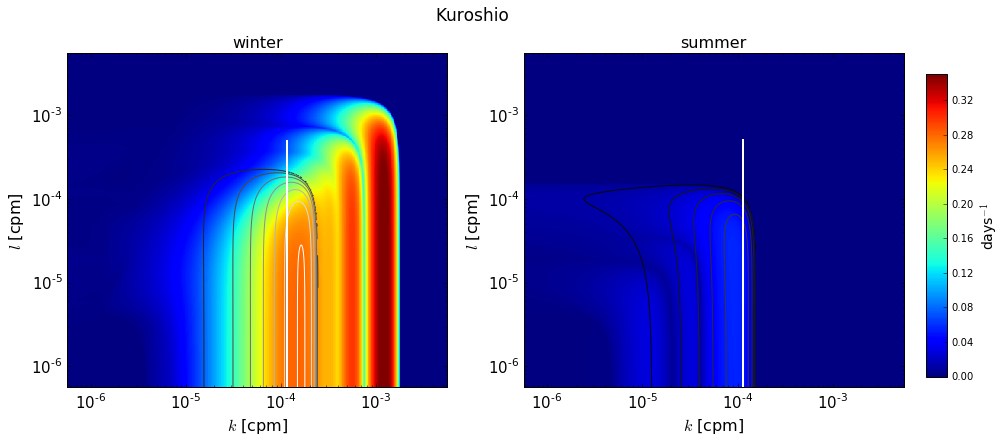

In [49]:
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(121)
im = ax1.pcolormesh(k_winK[Nwv:]*.5*np.pi**-1, l_winK*.5*np.pi**-1, 
                    sigma2D_winK[:, Nwv:]*24*3600,
              vmin=0., vmax=.35)
cnt1 = ax1.contour(k_winK[Nwv:]*.5*np.pi**-1, l_winK*.5*np.pi**-1, 
                   Eady_winKuro[:, Nwv:]*24*3600,
                 cmap=cm.gray, vmin=0., vmax=.35)
ax1.plot(kr_Kuro, np.linspace((l_winK*.5*np.pi**-1).min(), 
                              5e-4, 100), 'w', lw=2)
# ax1.semilogx(k_winK[Nwv:], Eady_winKuro1D[Nwv:]*24*3600)
ax1.set_title(r'winter', fontsize=16)
ax1.set_xlabel(r'$k$ [cpm]', fontsize=16)
ax1.set_ylabel(r'$l$ [cpm]', fontsize=16)
plt.xlim([(k_winK[Nwv:]*.5*np.pi**-1).min(), (k_winK[Nwv:]*.5*np.pi**-1).max()])
plt.ylim([(l_winK*.5*np.pi**-1).min(), (l_winK*.5*np.pi**-1).max()])
# ax1.clabel(cnt1, fontsize=10)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

ax2 = fig.add_subplot(122)
im = ax2.pcolormesh(k_sumK[Nwv:]*.5*np.pi**-1, l_sumK*.5*np.pi**-1, 
                    sigma2D_sumK[:, Nwv:]*24*3600,
              vmin=0., vmax=.35)
cnt2 = ax2.contour(k_sumK[Nwv:]*.5*np.pi**-1, l_sumK*.5*np.pi**-1, 
                   Eady_sumKuro[:, Nwv:]*24*3600,
                 cmap=cm.gray, vmin=0., vmax=.35)
ax2.plot(kr_Kuro, np.linspace((l_sumK*.5*np.pi**-1).min(), 
                              5e-4, 100), 'w', lw=2)
# ax2.plot(kr_Kuro, np.ones(100), 'w')
# ax2.clabel(cnt2, fontsize=10)
# plt.clabel(cnt2, inline=1, fontsize=10)
ax2.set_title(r'summer', fontsize=16)
ax2.set_xlabel(r'$k$ [cpm]', fontsize=16)
ax2.set_ylabel(r'$l$ [cpm]', fontsize=16)
plt.xlim([(k_sumK[Nwv:]*.5*np.pi**-1).min(), (k_sumK[Nwv:]*.5*np.pi**-1).max()])
plt.ylim([(l_sumK*.5*np.pi**-1).min(), (l_sumK*.5*np.pi**-1).max()])
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.suptitle('Kuroshio', fontsize=17, y=1.007)
cbar_axim = fig.add_axes([0.92, 0.15, 0.02, 0.7])
# cbar_axcnt = fig.add_axes([0.98, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_axim)
# cbar = fig.colorbar(cnt, cbar_axcnt)
cbar.set_label(r'days$^{-1}$', fontsize=14)
plt.savefig('POP_Kuroshio_2Dgrowthrate.png', bbox_inches='tight')

## North of Kuroshio

In [60]:
lats_NK = (44., 45.)
lons_NK = (1.71900000e+02, 1.72900000e+02)

In [61]:
dx_NK = dx_meta.sel(Latitude_t=slice(lats_NK[0], lats_NK[1]), 
                    Longitude_t=slice(lons_NK[0], lons_NK[1])).values.copy()
dy_NK = dy_meta.sel(Latitude_t=slice(lats_NK[0], lats_NK[1]), 
                    Longitude_t=slice(lons_NK[0], lons_NK[1])).values.copy()

kr_NK = np.ones(100) * dx_NK[jy, ix]**-1

In [62]:
Ug_winNK = Ug_winmeta.sel(Latitude_t=slice(lats_NK[0], lats_NK[1]), 
                    Longitude_t=slice(lons_NK[0], lons_NK[1])).values.copy()
lat_NK = Ug_winmeta.sel(Latitude_t=slice(lats_NK[0], lats_NK[1]), 
                     Longitude_t=slice(lons_NK[0], lons_NK[1])).Latitude_t.values.copy()
lon_NK = Ug_winmeta.sel(Latitude_t=slice(lats_NK[0], lats_NK[1]), 
                     Longitude_t=slice(lons_NK[0], lons_NK[1])).Longitude_t.values.copy()
Vg_winNK = Vg_winmeta.sel(Latitude_t=slice(lats_NK[0], lats_NK[1]), 
                    Longitude_t=slice(lons_NK[0], lons_NK[1])).values.copy()
N2_winNK = N2_winmeta.sel(Latitude_t=slice(lats_NK[0], lats_NK[1]),
                    Longitude_t=slice(lons_NK[0], lons_NK[1])).values.copy()
zN2_winNK = zN2_winmeta.sel(Latitude_t=slice(lats_NK[0], lats_NK[1]), 
                       Longitude_t=slice(lons_NK[0], lons_NK[1])).values.copy()
    
MLD_winNK = MLD_winmeta.sel(Latitude_t=slice(lats_NK[0], lats_NK[1]), 
                       Longitude_t=slice(lons_NK[0], lons_NK[1])).values.copy()
H_winNK = H_winmeta.sel(Latitude_t=slice(lats_NK[0], lats_NK[1]), 
                   Longitude_t=slice(lons_NK[0], lons_NK[1])).values.copy()
    
Ri_winNK = Ri_winmeta.sel(Latitude_t=slice(lats_NK[0], lats_NK[1]), 
                     Longitude_t=slice(lons_NK[0], lons_NK[1])).values.copy()

In [63]:
Rix_winNK = Rix_winmeta.sel(Latitude_t=slice(lats_NK[0], lats_NK[1]), 
                     Longitude_t=slice(lons_NK[0], lons_NK[1])).values.copy()
Riy_winNK = Riy_winmeta.sel(Latitude_t=slice(lats_NK[0], lats_NK[1]), 
                     Longitude_t=slice(lons_NK[0], lons_NK[1])).values.copy()
kz_winNK = kz_winmeta.sel(Latitude_t=slice(lats_NK[0], lats_NK[1]), 
                     Longitude_t=slice(lons_NK[0], lons_NK[1])).values.copy()

In [64]:
Ug_sumNK = Ug_summeta.sel(Latitude_t=slice(lats_NK[0], lats_NK[1]), 
                    Longitude_t=slice(lons_NK[0], lons_NK[1])).values.copy()
Vg_sumNK = Vg_summeta.sel(Latitude_t=slice(lats_NK[0], lats_NK[1]), 
                    Longitude_t=slice(lons_NK[0], lons_NK[1])).values.copy()
N2_sumNK = N2_summeta.sel(Latitude_t=slice(lats_NK[0], lats_NK[1]),
                    Longitude_t=slice(lons_NK[0], lons_NK[1])).values.copy()
zN2_sumNK = zN2_summeta.sel(Latitude_t=slice(lats_NK[0], lats_NK[1]), 
                       Longitude_t=slice(lons_NK[0], lons_NK[1])).values.copy()
    
MLD_sumNK = MLD_summeta.sel(Latitude_t=slice(lats_NK[0], lats_NK[1]), 
                       Longitude_t=slice(lons_NK[0], lons_NK[1])).values.copy()
H_sumNK = H_summeta.sel(Latitude_t=slice(lats_NK[0], lats_NK[1]), 
                   Longitude_t=slice(lons_NK[0], lons_NK[1])).values.copy()
    
Ri_sumNK = Ri_summeta.sel(Latitude_t=slice(lats_NK[0], lats_NK[1]), 
                     Longitude_t=slice(lons_NK[0], lons_NK[1])).values.copy()

In [65]:
Rix_sumNK = Rix_summeta.sel(Latitude_t=slice(lats_NK[0], lats_NK[1]), 
                     Longitude_t=slice(lons_NK[0], lons_NK[1])).values.copy()
Riy_sumNK = Riy_summeta.sel(Latitude_t=slice(lats_NK[0], lats_NK[1]), 
                     Longitude_t=slice(lons_NK[0], lons_NK[1])).values.copy()
kz_sumNK = kz_summeta.sel(Latitude_t=slice(lats_NK[0], lats_NK[1]), 
                     Longitude_t=slice(lons_NK[0], lons_NK[1])).values.copy()

In [66]:
zphi, Rd, vd = baroclinic.neutral_modes_from_N2_profile(-zN2_winNK[:, jy, ix], 
                                                                                N2_winNK[:, jy, ix], gsw.earth.f(lat_NK[jy]), **kwargs)

Rd_winNK = Rd[1]

In [67]:
k_winNK, l_winNK, sigma2D_winNK, amp2D_winNK = baroclinic_instability(zN2_winNK[:, jy, ix], 
                                                                               N2_winNK[:, jy, ix], lat_NK[jy], zU, 
                                                                               Ug_winNK[:, jy, ix], Vg_winNK[:, jy, ix], 
                                                                               etax, etay, Rd_winNK, kmin=0.1, kmax=1e3,
                                                                               Nwv=Nwv)

In [68]:
np.savez('POP_barocliGrowthrate_NorthofKuroshio_win',
        k=k_winNK, l=l_winNK,
        growthrate=sigma2D_winNK, amplitude=amp2D_winNK)

In [92]:
NKwinnpz = np.load(os.path.join(basedir, 'POP_barocliGrowthrate_NorthofKuroshio_win.npz'))
print NKwinnpz.files
k_winNK = NKwinnpz['k']
l_winNK = NKwinnpz['l']
sigma2D_winNK = NKwinnpz['growthrate']
amp2D_winNK = NKwinnpz['amplitude']

['k', 'l', 'amplitude', 'growthrate']


In [69]:
zphi, Rd, vd = baroclinic.neutral_modes_from_N2_profile(-zN2_sumNK[:, jy, ix], 
                                                                                N2_sumNK[:, jy, ix], gsw.earth.f(lat_NK[jy]), **kwargs)

Rd_sumNK = Rd[1]

In [70]:
k_sumNK, l_sumNK, sigma2D_sumNK, amp2D_sumNK = baroclinic_instability(zN2_sumNK[:, jy, ix], 
                                                                               N2_sumNK[:, jy, ix], lat_NK[jy], zU, 
                                                                               Ug_sumNK[:, jy, ix], Vg_sumNK[:, jy, ix], 
                                                                               etax, etay, Rd_sumNK, kmin=0.1, kmax=1e3,
                                                                               Nwv=Nwv)

In [71]:
np.savez('POP_barocliGrowthrate_NorthofKuroshio_sum',
        k=k_sumNK, l=l_sumNK,
        growthrate=sigma2D_sumNK, amplitude=amp2D_sumNK)

In [93]:
NKsumnpz = np.load(os.path.join(basedir, 'POP_barocliGrowthrate_NorthofKuroshio_sum.npz'))
print NKsumnpz.files
k_sumNK = NKsumnpz['k']
l_sumNK = NKsumnpz['l']
sigma2D_sumNK = NKsumnpz['growthrate']
amp2D_sumNK = NKsumnpz['amplitude']

['k', 'l', 'amplitude', 'growthrate']


In [72]:
Rd_MLwinNK = RdML(int(kz_winNK[jy, ix]), MLD_winNK[jy, ix],
                   lat_NK[jy], zN2_winNK[:, jy, ix], N2_winNK[:, jy, ix], dzU)

In [73]:
mu_NKwin, Eady_winNK = Eady_growthrate(lat_NK[jy], MLD_winNK[jy, ix], 
                            dzU, Rix_winNK[:, jy, ix], k_winNK, Rd_MLwinNK, Ri_y=Riy_winNK[:, jy, ix],
                            l=l_winNK, kz=int(kz_winNK[jy, ix]), dim=2)

In [74]:
Rd_MLsumNK = RdML(int(kz_sumNK[jy, ix]), MLD_sumNK[jy, ix],
                   lat_NK[jy], zN2_sumNK[:, jy, ix], N2_sumNK[:, jy, ix], dzU)

In [75]:
mu_NKsum, Eady_sumNK = Eady_growthrate(lat_NK[jy], MLD_sumNK[jy, ix], 
                            dzU, Rix_sumNK[:, jy, ix], k_sumNK, Rd_MLsumNK, Ri_y=Riy_sumNK[:, jy, ix],
                            l=l_sumNK, kz=int(kz_sumNK[jy, ix]), dim=2)

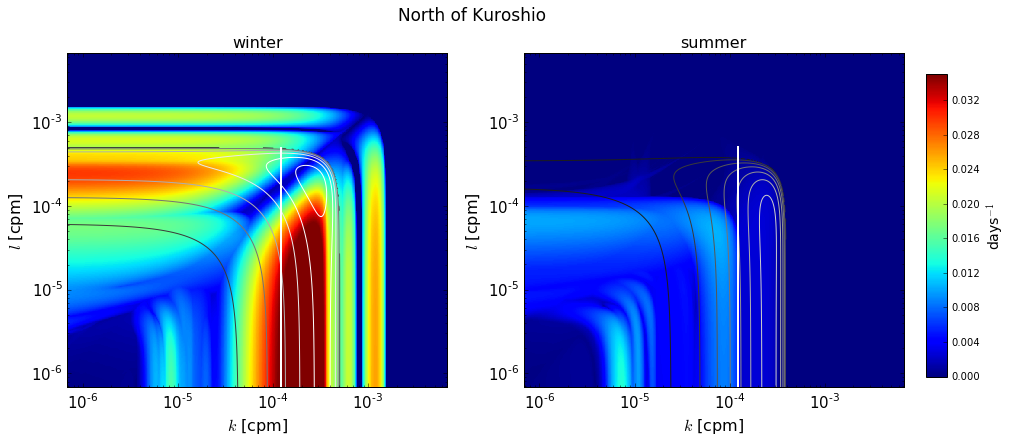

In [76]:
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(121)
im = ax1.pcolormesh(k_winNK[Nwv:]*.5*np.pi**-1, l_winNK*.5*np.pi**-1, 
                    sigma2D_winNK[:, Nwv:]*24*3600,
              vmin=0., vmax=.035)
cnt1 = ax1.contour(k_winNK[Nwv:]*.5*np.pi**-1, l_winNK*.5*np.pi**-1, 
                   Eady_winNK[:, Nwv:]*24*3600,
                 cmap=cm.gray, vmin=0., vmax=.035)
ax1.plot(kr_NK, np.linspace((l_winNK*.5*np.pi**-1).min(), 
                              5e-4, 100), 'w', lw=2)
# ax1.semilogx(k_winK[Nwv:], Eady_winKuro1D[Nwv:]*24*3600)
ax1.set_title(r'winter', fontsize=16)
ax1.set_xlabel(r'$k$ [cpm]', fontsize=16)
ax1.set_ylabel(r'$l$ [cpm]', fontsize=16)
# ax1.clabel(cnt1, fontsize=10)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

ax2 = fig.add_subplot(122)
im = ax2.pcolormesh(k_sumNK[Nwv:]*.5*np.pi**-1, l_sumNK*.5*np.pi**-1, 
                    sigma2D_sumNK[:, Nwv:]*24*3600,
              vmin=0., vmax=.035)
cnt2 = ax2.contour(k_sumNK[Nwv:]*.5*np.pi**-1, l_sumNK*.5*np.pi**-1, 
                   Eady_sumNK[:, Nwv:]*24*3600,
                 cmap=cm.gray, vmin=0., vmax=.035)
ax2.plot(kr_NK, np.linspace((l_sumNK*.5*np.pi**-1).min(), 
                              5e-4, 100), 'w', lw=2)
# ax2.clabel(cnt2, fontsize=10)
# plt.clabel(cnt2, inline=1, fontsize=10)
ax2.set_title(r'summer', fontsize=16)
ax2.set_xlabel(r'$k$ [cpm]', fontsize=16)
ax2.set_ylabel(r'$l$ [cpm]', fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.suptitle('North of Kuroshio', fontsize=17, y=1.007)
cbar_axim = fig.add_axes([0.92, 0.15, 0.02, 0.7])
# cbar_axcnt = fig.add_axes([0.98, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_axim)
# cbar = fig.colorbar(cnt, cbar_axcnt)
cbar.set_label(r'days$^{-1}$', fontsize=14)
plt.savefig('POP_NorthofKuroshio_2Dgrowthrate.png', bbox_inches='tight')

## East Pacific

In [77]:
lats_EP = (17., 18.)
lons_EP = (2.39900000e+02, 2.40900000e+02)

In [78]:
dx_EP = dx_meta.sel(Latitude_t=slice(lats_EP[0], lats_EP[1]), 
                    Longitude_t=slice(lons_EP[0], lons_EP[1])).values.copy()
dy_EP = dy_meta.sel(Latitude_t=slice(lats_NK[0], lats_EP[1]), 
                    Longitude_t=slice(lons_EP[0], lons_EP[1])).values.copy()

kr_EP = np.ones(100) * dx_EP[jy, ix]**-1

In [79]:
Ug_winEP = Ug_winmeta.sel(Latitude_t=slice(lats_EP[0], lats_EP[1]), 
                    Longitude_t=slice(lons_EP[0], lons_EP[1])).values.copy()
lat_EP = Ug_winmeta.sel(Latitude_t=slice(lats_EP[0], lats_EP[1]), 
                    Longitude_t=slice(lons_EP[0], lons_EP[1])).Latitude_t.values.copy()
lon_EP = Ug_winmeta.sel(Latitude_t=slice(lats_EP[0], lats_EP[1]), 
                    Longitude_t=slice(lons_EP[0], lons_EP[1])).Longitude_t.values.copy()
Vg_winEP = Vg_winmeta.sel(Latitude_t=slice(lats_EP[0], lats_EP[1]), 
                    Longitude_t=slice(lons_EP[0], lons_EP[1])).values.copy()
N2_winEP = N2_winmeta.sel(Latitude_t=slice(lats_EP[0], lats_EP[1]), 
                    Longitude_t=slice(lons_EP[0], lons_EP[1])).values.copy()
zN2_winEP = zN2_winmeta.sel(Latitude_t=slice(lats_EP[0], lats_EP[1]), 
                    Longitude_t=slice(lons_EP[0], lons_EP[1])).values.copy()
    
MLD_winEP = MLD_winmeta.sel(Latitude_t=slice(lats_EP[0], lats_EP[1]), 
                    Longitude_t=slice(lons_EP[0], lons_EP[1])).values.copy()
H_winEP = H_winmeta.sel(Latitude_t=slice(lats_EP[0], lats_EP[1]), 
                    Longitude_t=slice(lons_EP[0], lons_EP[1])).values.copy()
    
Ri_winEP = Ri_winmeta.sel(Latitude_t=slice(lats_EP[0], lats_EP[1]), 
                    Longitude_t=slice(lons_EP[0], lons_EP[1])).values.copy()

In [80]:
Rix_winEP = Rix_winmeta.sel(Latitude_t=slice(lats_EP[0], lats_EP[1]), 
                    Longitude_t=slice(lons_EP[0], lons_EP[1])).values.copy()
Riy_winEP = Riy_winmeta.sel(Latitude_t=slice(lats_EP[0], lats_EP[1]), 
                    Longitude_t=slice(lons_EP[0], lons_EP[1])).values.copy()
kz_winEP = kz_winmeta.sel(Latitude_t=slice(lats_EP[0], lats_EP[1]), 
                    Longitude_t=slice(lons_EP[0], lons_EP[1])).values.copy()

In [81]:
Ug_sumEP = Ug_summeta.sel(Latitude_t=slice(lats_EP[0], lats_EP[1]), 
                    Longitude_t=slice(lons_EP[0], lons_EP[1])).values.copy()
Vg_sumEP = Vg_summeta.sel(Latitude_t=slice(lats_EP[0], lats_EP[1]), 
                    Longitude_t=slice(lons_EP[0], lons_EP[1])).values.copy()
N2_sumEP = N2_summeta.sel(Latitude_t=slice(lats_EP[0], lats_EP[1]), 
                    Longitude_t=slice(lons_EP[0], lons_EP[1])).values.copy()
zN2_sumEP = zN2_summeta.sel(Latitude_t=slice(lats_EP[0], lats_EP[1]), 
                    Longitude_t=slice(lons_EP[0], lons_EP[1])).values.copy()
    
MLD_sumEP = MLD_summeta.sel(Latitude_t=slice(lats_EP[0], lats_EP[1]), 
                    Longitude_t=slice(lons_EP[0], lons_EP[1])).values.copy()
H_sumEP = H_summeta.sel(Latitude_t=slice(lats_EP[0], lats_EP[1]), 
                    Longitude_t=slice(lons_EP[0], lons_EP[1])).values.copy()
    
Ri_sumEP = Ri_summeta.sel(Latitude_t=slice(lats_EP[0], lats_EP[1]), 
                    Longitude_t=slice(lons_EP[0], lons_EP[1])).values.copy()

In [82]:
Rix_sumEP = Rix_summeta.sel(Latitude_t=slice(lats_EP[0], lats_EP[1]), 
                    Longitude_t=slice(lons_EP[0], lons_EP[1])).values.copy()
Riy_sumEP = Riy_summeta.sel(Latitude_t=slice(lats_EP[0], lats_EP[1]), 
                    Longitude_t=slice(lons_EP[0], lons_EP[1])).values.copy()
kz_sumEP = kz_summeta.sel(Latitude_t=slice(lats_EP[0], lats_EP[1]), 
                    Longitude_t=slice(lons_EP[0], lons_EP[1])).values.copy()

In [ ]:
zphi, Rd, vd = baroclinic.neutral_modes_from_N2_profile(-zN2_winEP[:, jy, ix], 
                                                                                N2_winEP[:, jy, ix], gsw.earth.f(lat_EP[jy]), **kwargs)

Rd_winEP = Rd[1]

In [ ]:
k_winEP, l_winEP, sigma2D_winEP, amp2D_winEP = baroclinic_instability(zN2_winEP[:, jy, ix], 
                                                                               N2_winEP[:, jy, ix], lat_EP[jy], zU, 
                                                                               Ug_winEP[:, jy, ix], Vg_winEP[:, jy, ix], 
                                                                               etax, etay, Rd_winEP, kmin=0.1, kmax=1e3,
                                                                               Nwv=Nwv)

In [ ]:
np.savez('POP_barocliGrowthrate_EastPacific_win',
        k=k_winEP, l=l_winEP,
        growthrate=sigma2D_winEP, amplitude=amp2D_winEP)

In [ ]:
zphi, Rd, vd = baroclinic.neutral_modes_from_N2_profile(-zN2_sumEP[:, jy, ix], 
                                                                                N2_sumEP[:, jy, ix], gsw.earth.f(lat_EP[jy]), **kwargs)

Rd_sumEP = Rd[1]

In [ ]:
k_sumEP, l_sumEP, sigma2D_sumEP, amp2D_sumEP = baroclinic_instability(zN2_sumEP[:, jy, ix], 
                                                                               N2_sumEP[:, jy, ix], lat_EP[jy], zU, 
                                                                               Ug_sumEP[:, jy, ix], Vg_sumEP[:, jy, ix], 
                                                                               etax, etay, Rd_sumEP, kmin=0.1, kmax=1e3,
                                                                               Nwv=Nwv)

In [ ]:
np.savez('POP_barocliGrowthrate_EastPacific_sum',
        k=k_sumEP, l=l_sumEP,
        growthrate=sigma2D_sumEP, amplitude=amp2D_sumEP)

In [108]:
EPnpzwin = np.load(os.path.join(basedir, 'POP_barocliGrowthrate_EastPacific_win.npz'))
print EPnpzwin.files
k_winEP = EPnpzwin['k']
l_winEP = EPnpzwin['l']
sigma2D_winEP = EPnpzwin['growthrate']
amp2D_winEP = EPnpzwin['amplitude']

EPnpzsum = np.load(os.path.join(basedir, 'POP_barocliGrowthrate_EastPacific_sum.npz'))
print EPnpzsum.files
k_sumEP = EPnpzsum['k']
l_sumEP = EPnpzsum['l']
sigma2D_sumEP = EPnpzsum['growthrate']
amp2D_sumEP = EPnpzsum['amplitude']

['k', 'l', 'amplitude', 'growthrate']
['k', 'l', 'amplitude', 'growthrate']


In [ ]:
Rd_MLwinEP = RdML(int(kz_winEP[jy, ix]), MLD_winEP[jy, ix],
                   lat_EP[jy], zN2_winEP[:, jy, ix], N2_winEP[:, jy, ix], dzU)

In [ ]:
mu_EPwin, Eady_winEP = Eady_growthrate(lat_EP[jy], MLD_winEP[jy, ix], 
                            dzU, Rix_winEP[:, jy, ix], k_winEP, Rd_MLwinEP, Ri_y=Riy_winEP[:, jy, ix],
                            l=l_winEP, kz=int(kz_winEP[jy, ix]), dim=2)

In [ ]:
Rd_MLsumEP = RdML(int(kz_sumEP[jy, ix]), MLD_sumEP[jy, ix],
                   lat_EP[jy], zN2_sumEP[:, jy, ix], N2_sumEP[:, jy, ix], dzU)

In [ ]:
mu_EPsum, Eady_sumEP = Eady_growthrate(lat_EP[jy], MLD_sumEP[jy, ix], 
                            dzU, Rix_sumEP[:, jy, ix], k_sumEP, Rd_MLsumEP, Ri_y=Riy_sumEP[:, jy, ix],
                            l=l_sumEP, kz=int(kz_sumEP[jy, ix]), dim=2)

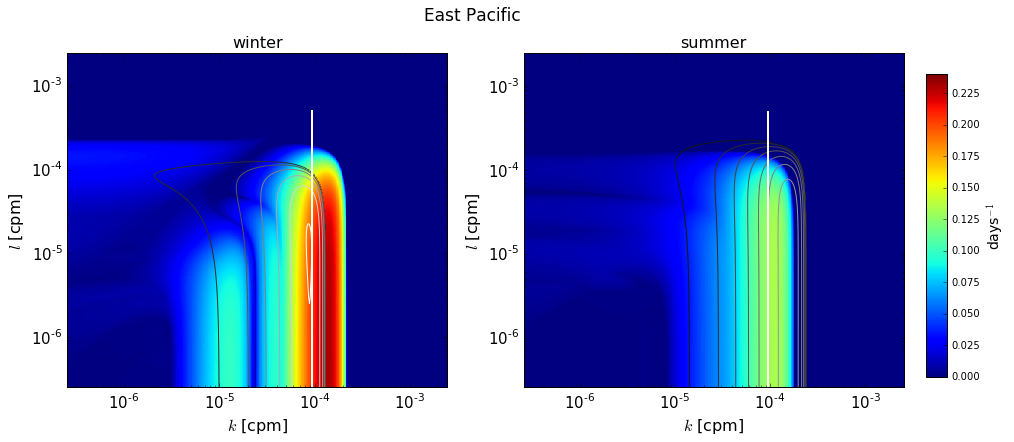

In [ ]:
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(121)
im = ax1.pcolormesh(k_winEP[Nwv:]*.5*np.pi**-1, l_winEP*.5*np.pi**-1, 
                    sigma2D_winEP[:, Nwv:]*24*3600,
              vmin=0., vmax=.24)
cnt1 = ax1.contour(k_winEP[Nwv:]*.5*np.pi**-1, l_winEP*.5*np.pi**-1, 
                   Eady_winEP[:, Nwv:]*24*3600,
                 cmap=cm.gray, vmin=0., vmax=.24)
ax1.plot(kr_EP, np.linspace((l_winEP*.5*np.pi**-1).min(), 
                              5e-4, 100), 'w', lw=2)
# ax1.semilogx(k_winK[Nwv:], Eady_winKuro1D[Nwv:]*24*3600)
ax1.set_title(r'winter', fontsize=16)
ax1.set_xlabel(r'$k$ [cpm]', fontsize=16)
ax1.set_ylabel(r'$l$ [cpm]', fontsize=16)
# ax1.clabel(cnt1, fontsize=10)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

ax2 = fig.add_subplot(122)
im = ax2.pcolormesh(k_sumEP[Nwv:]*.5*np.pi**-1, l_sumEP*.5*np.pi**-1, 
                    sigma2D_sumEP[:, Nwv:]*24*3600,
              vmin=0., vmax=.24)
cnt2 = ax2.contour(k_sumEP[Nwv:]*.5*np.pi**-1, l_sumEP*.5*np.pi**-1, 
                   Eady_sumEP[:, Nwv:]*24*3600,
                 cmap=cm.gray, vmin=0., vmax=.24)
ax2.plot(kr_EP, np.linspace((l_sumEP*.5*np.pi**-1).min(), 
                              5e-4, 100), 'w', lw=2)
# ax2.clabel(cnt2, fontsize=10)
# plt.clabel(cnt2, inline=1, fontsize=10)
ax2.set_title(r'summer', fontsize=16)
ax2.set_xlabel(r'$k$ [cpm]', fontsize=16)
ax2.set_ylabel(r'$l$ [cpm]', fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.suptitle('East Pacific', fontsize=17, y=1.007)
cbar_axim = fig.add_axes([0.92, 0.15, 0.02, 0.7])
# cbar_axcnt = fig.add_axes([0.98, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_axim)
# cbar = fig.colorbar(cnt, cbar_axcnt)
cbar.set_label(r'days$^{-1}$', fontsize=14)
plt.savefig('POP_EastPacific_2Dgrowthrate.png', bbox_inches='tight')

# Atlantic

## Gulf Stream

In [50]:
lats_GS = (41., 42.)
lons_GS = (2.99900000e+02, 3.00900000e+02)

In [51]:
dx_GS = dx_meta.sel(Latitude_t=slice(lats_GS[0], lats_GS[1]), 
                    Longitude_t=slice(lons_GS[0], lons_GS[1])).values.copy()
dy_GS = dy_meta.sel(Latitude_t=slice(lats_GS[0], lats_GS[1]), 
                    Longitude_t=slice(lons_GS[0], lons_GS[1])).values.copy()

kr_GS = np.ones(100) * dx_GS[jy, ix]**-1

In [52]:
Ug_winGS = Ug_winmeta.sel(Latitude_t=slice(lats_GS[0], lats_GS[1]), 
                    Longitude_t=slice(lons_GS[0], lons_GS[1])).values.copy()
lat_GS = Ug_winmeta.sel(Latitude_t=slice(lats_GS[0], lats_GS[1]), 
                    Longitude_t=slice(lons_GS[0], lons_GS[1])).Latitude_t.values.copy()
lon_GS = Ug_winmeta.sel(Latitude_t=slice(lats_GS[0], lats_GS[1]), 
                    Longitude_t=slice(lons_GS[0], lons_GS[1])).Longitude_t.values.copy()
Vg_winGS = Vg_winmeta.sel(Latitude_t=slice(lats_GS[0], lats_GS[1]), 
                    Longitude_t=slice(lons_GS[0], lons_GS[1])).values.copy()
N2_winGS = N2_winmeta.sel(Latitude_t=slice(lats_GS[0], lats_GS[1]), 
                    Longitude_t=slice(lons_GS[0], lons_GS[1])).values.copy()
zN2_winGS = zN2_winmeta.sel(Latitude_t=slice(lats_GS[0], lats_GS[1]), 
                    Longitude_t=slice(lons_GS[0], lons_GS[1])).values.copy()
    
MLD_winGS = MLD_winmeta.sel(Latitude_t=slice(lats_GS[0], lats_GS[1]), 
                    Longitude_t=slice(lons_GS[0], lons_GS[1])).values.copy()
H_winGS = H_winmeta.sel(Latitude_t=slice(lats_GS[0], lats_GS[1]), 
                    Longitude_t=slice(lons_GS[0], lons_GS[1])).values.copy()
    
Ri_winGS = Ri_winmeta.sel(Latitude_t=slice(lats_GS[0], lats_GS[1]), 
                    Longitude_t=slice(lons_GS[0], lons_GS[1])).values.copy()

In [53]:
Rix_winGS = Rix_winmeta.sel(Latitude_t=slice(lats_GS[0], lats_GS[1]), 
                    Longitude_t=slice(lons_GS[0], lons_GS[1])).values.copy()
Riy_winGS = Riy_winmeta.sel(Latitude_t=slice(lats_GS[0], lats_GS[1]), 
                    Longitude_t=slice(lons_GS[0], lons_GS[1])).values.copy()
kz_winGS = kz_winmeta.sel(Latitude_t=slice(lats_GS[0], lats_GS[1]), 
                    Longitude_t=slice(lons_GS[0], lons_GS[1])).values.copy()

In [54]:
Ug_sumGS = Ug_summeta.sel(Latitude_t=slice(lats_GS[0], lats_GS[1]), 
                    Longitude_t=slice(lons_GS[0], lons_GS[1])).values.copy()
Vg_sumGS = Vg_summeta.sel(Latitude_t=slice(lats_GS[0], lats_GS[1]), 
                    Longitude_t=slice(lons_GS[0], lons_GS[1])).values.copy()
N2_sumGS = N2_summeta.sel(Latitude_t=slice(lats_GS[0], lats_GS[1]), 
                    Longitude_t=slice(lons_GS[0], lons_GS[1])).values.copy()
zN2_sumGS = zN2_summeta.sel(Latitude_t=slice(lats_GS[0], lats_GS[1]), 
                    Longitude_t=slice(lons_GS[0], lons_GS[1])).values.copy()
    
MLD_sumGS = MLD_summeta.sel(Latitude_t=slice(lats_GS[0], lats_GS[1]), 
                    Longitude_t=slice(lons_GS[0], lons_GS[1])).values.copy()
H_sumGS = H_summeta.sel(Latitude_t=slice(lats_GS[0], lats_GS[1]), 
                    Longitude_t=slice(lons_GS[0], lons_GS[1])).values.copy()
    
Ri_sumGS = Ri_summeta.sel(Latitude_t=slice(lats_GS[0], lats_GS[1]), 
                    Longitude_t=slice(lons_GS[0], lons_GS[1])).values.copy()

In [55]:
Rix_sumGS = Rix_summeta.sel(Latitude_t=slice(lats_GS[0], lats_GS[1]), 
                    Longitude_t=slice(lons_GS[0], lons_GS[1])).values.copy()
Riy_sumGS = Riy_summeta.sel(Latitude_t=slice(lats_GS[0], lats_GS[1]), 
                    Longitude_t=slice(lons_GS[0], lons_GS[1])).values.copy()
kz_sumGS = kz_summeta.sel(Latitude_t=slice(lats_GS[0], lats_GS[1]), 
                    Longitude_t=slice(lons_GS[0], lons_GS[1])).values.copy()

In [ ]:
zphi, Rd, vd = baroclinic.neutral_modes_from_N2_profile(-zN2_winGS[:, jy, ix], 
                                                                                N2_winGS[:, jy, ix], gsw.earth.f(lat_GS[jy]), **kwargs)

Rd_winGS = Rd[1]

In [ ]:
k_winGS, l_winGS, sigma2D_winGS, amp2D_winGS = baroclinic_instability(zN2_winGS[:, jy, ix], 
                                                                               N2_winGS[:, jy, ix], lat_GS[jy], zU, 
                                                                               Ug_winGS[:, jy, ix], Vg_winGS[:, jy, ix], 
                                                                               etax, etay, Rd_winGS, kmin=0.1, kmax=1e3,
                                                                               Nwv=Nwv)

In [ ]:
np.savez('POP_barocliGrowthrate_GulfStream_win',
        k=k_winGS, l=l_winGS,
        growthrate=sigma2D_winGS, amplitude=amp2D_winGS)

In [ ]:
zphi, Rd, vd = baroclinic.neutral_modes_from_N2_profile(-zN2_sumGS[:, jy, ix], 
                                                                                N2_sumGS[:, jy, ix], gsw.earth.f(lat_GS[jy]), **kwargs)

Rd_sumGS = Rd[1]

In [ ]:
k_sumGS, l_sumGS, sigma2D_sumGS, amp2D_sumGS = baroclinic_instability(zN2_sumGS[:, jy, ix], 
                                                                               N2_sumGS[:, jy, ix], lat_GS[jy], zU, 
                                                                               Ug_sumGS[:, jy, ix], Vg_sumGS[:, jy, ix], 
                                                                               etax, etay, Rd_sumGS, kmin=0.1, kmax=1e3,
                                                                               Nwv=Nwv)

In [ ]:
np.savez('POP_barocliGrowthrate_GulfStream_sum',
        k=k_sumGS, l=l_sumGS,
        growthrate=sigma2D_sumGS, amplitude=amp2D_sumGS)

In [56]:
GSwinnpz = np.load(os.path.join(basedir, 'POP_barocliGrowthrate_GulfStream_win.npz'))
print GSwinnpz.files
k_winGS = GSwinnpz['k']
l_winGS = GSwinnpz['l']
sigma2D_winGS = GSwinnpz['growthrate']
amp2D_winGS = GSwinnpz['amplitude']

GSsumnpz = np.load(os.path.join(basedir, 'POP_barocliGrowthrate_GulfStream_sum.npz'))
print GSsumnpz.files
k_sumGS = GSsumnpz['k']
l_sumGS = GSsumnpz['l']
sigma2D_sumGS = GSsumnpz['growthrate']
amp2D_sumGS = GSsumnpz['amplitude']

['k', 'l', 'amplitude', 'growthrate']
['k', 'l', 'amplitude', 'growthrate']


In [57]:
Rd_MLwinGS = RdML(int(kz_winGS[jy, ix]), MLD_winGS[jy, ix],
                   lat_GS[jy], zN2_winGS[:, jy, ix], N2_winGS[:, jy, ix], dzU)

In [58]:
mu_winGS, Eady_winGS = Eady_growthrate(lat_GS[jy], MLD_winGS[jy, ix], 
                            dzU, Rix_winGS[:, jy, ix], k_winGS, Rd_MLwinGS, Ri_y=Riy_winGS[:, jy, ix],
                            l=l_winGS, kz=int(kz_winGS[jy, ix]), dim=2)

In [59]:
Rd_MLsumGS = RdML(int(kz_sumGS[jy, ix]), MLD_sumGS[jy, ix],
                   lat_GS[jy], zN2_sumGS[:, jy, ix], N2_sumGS[:, jy, ix], dzU)

In [60]:
mu_sumGS, Eady_sumGS = Eady_growthrate(lat_GS[jy], MLD_sumGS[jy, ix], 
                            dzU, Rix_sumGS[:, jy, ix], k_sumGS, Rd_MLsumGS, Ri_y=Riy_sumGS[:, jy, ix],
                            l=l_sumGS, kz=int(kz_sumGS[jy, ix]), dim=2)

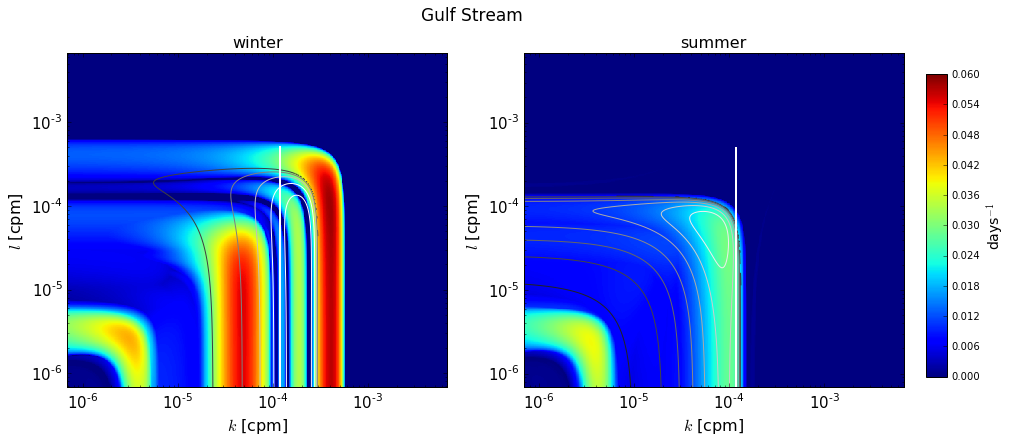

In [61]:
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(121)
im = ax1.pcolormesh(k_winGS[Nwv:]*.5*np.pi**-1, l_winGS*.5*np.pi**-1, sigma2D_winGS[:, Nwv:]*24*3600,
              vmin=0., vmax=.06)
cnt1 = ax1.contour(k_winGS[Nwv:]*.5*np.pi**-1, l_winGS*.5*np.pi**-1, Eady_winGS[:, Nwv:]*24*3600,
                 cmap=cm.gray, vmin=0., vmax=.06)
ax1.plot(kr_GS, np.linspace((l_winGS*.5*np.pi**-1).min(), 
                              5e-4, 100), 'w', lw=2)
# ax1.semilogx(k_winK[Nwv:], Eady_winKuro1D[Nwv:]*24*3600)
ax1.set_title(r'winter', fontsize=16)
ax1.set_xlabel(r'$k$ [cpm]', fontsize=16)
ax1.set_ylabel(r'$l$ [cpm]', fontsize=16)
# ax1.clabel(cnt1, fontsize=10)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

ax2 = fig.add_subplot(122)
im = ax2.pcolormesh(k_sumGS[Nwv:]*.5*np.pi**-1, l_sumGS*.5*np.pi**-1, sigma2D_sumGS[:, Nwv:]*24*3600,
              vmin=0., vmax=.06)
cnt2 = ax2.contour(k_sumGS[Nwv:]*.5*np.pi**-1, l_sumGS*.5*np.pi**-1, Eady_sumGS[:, Nwv:]*24*3600,
                 cmap=cm.gray, vmin=0., vmax=.06)
ax2.plot(kr_GS, np.linspace((l_sumGS*.5*np.pi**-1).min(), 
                              5e-4, 100), 'w', lw=2)
# ax2.clabel(cnt2, fontsize=10)
# plt.clabel(cnt2, inline=1, fontsize=10)
ax2.set_title(r'summer', fontsize=16)
ax2.set_xlabel(r'$k$ [cpm]', fontsize=16)
ax2.set_ylabel(r'$l$ [cpm]', fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


plt.suptitle('Gulf Stream', fontsize=17, y=1.007)
cbar_axim = fig.add_axes([0.92, 0.15, 0.02, 0.7])
# cbar_axcnt = fig.add_axes([0.98, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_axim)
# cbar = fig.colorbar(cnt, cbar_axcnt)
cbar.set_label(r'days$^{-1}$', fontsize=14)
plt.savefig('POP_GulfStream_2Dgrowthrate.png', bbox_inches='tight')

## Northeast Atlantic

In [ ]:
lats_NEAt = (55., 56.)
lons_NEAt = (3.39900000e+02, 3.40900000e+02)

In [ ]:
dx_NEAt = dx_meta.sel(Latitude_t=slice(lats_NEAt[0], lats_NEAt[1]), 
                    Longitude_t=slice(lons_NEAt[0], lons_NEAt[1])).values.copy()
dy_NEAt = dy_meta.sel(Latitude_t=slice(lats_NEAt[0], lats_NEAt[1]), 
                    Longitude_t=slice(lons_NEAt[0], lons_NEAt[1])).values.copy()

kr_NEAt = np.ones(100) * dx_NEAt[jy, ix]**-1

In [ ]:
Ug_winNEAt = Ug_winmeta.sel(Latitude_t=slice(lats_NEAt[0], lats_NEAt[1]), 
                    Longitude_t=slice(lons_NEAt[0], lons_NEAt[1])).values.copy()
lat_NEAt = Ug_winmeta.sel(Latitude_t=slice(lats_NEAt[0], lats_NEAt[1]), 
                    Longitude_t=slice(lons_NEAt[0], lons_NEAt[1])).Latitude_t.values.copy()
lon_NEAt = Ug_winmeta.sel(Latitude_t=slice(lats_NEAt[0], lats_NEAt[1]), 
                    Longitude_t=slice(lons_NEAt[0], lons_NEAt[1])).Longitude_t.values.copy()
Vg_winNEAt = Vg_winmeta.sel(Latitude_t=slice(lats_NEAt[0], lats_NEAt[1]), 
                    Longitude_t=slice(lons_NEAt[0], lons_NEAt[1])).values.copy()
N2_winNEAt = N2_winmeta.sel(Latitude_t=slice(lats_NEAt[0], lats_NEAt[1]), 
                    Longitude_t=slice(lons_NEAt[0], lons_NEAt[1])).values.copy()
zN2_winNEAt = zN2_winmeta.sel(Latitude_t=slice(lats_NEAt[0], lats_NEAt[1]), 
                    Longitude_t=slice(lons_NEAt[0], lons_NEAt[1])).values.copy()
    
MLD_winNEAt = MLD_winmeta.sel(Latitude_t=slice(lats_NEAt[0], lats_NEAt[1]), 
                    Longitude_t=slice(lons_NEAt[0], lons_NEAt[1])).values.copy()
H_winNEAt = H_winmeta.sel(Latitude_t=slice(lats_NEAt[0], lats_NEAt[1]), 
                    Longitude_t=slice(lons_NEAt[0], lons_NEAt[1])).values.copy()
    
Ri_winNEAt = Ri_winmeta.sel(Latitude_t=slice(lats_NEAt[0], lats_NEAt[1]), 
                    Longitude_t=slice(lons_NEAt[0], lons_NEAt[1])).values.copy()

In [ ]:
Rix_winNEAt = Rix_winmeta.sel(Latitude_t=slice(lats_NEAt[0], lats_NEAt[1]), 
                    Longitude_t=slice(lons_NEAt[0], lons_NEAt[1])).values.copy()
Riy_winNEAt = Riy_winmeta.sel(Latitude_t=slice(lats_NEAt[0], lats_NEAt[1]), 
                    Longitude_t=slice(lons_NEAt[0], lons_NEAt[1])).values.copy()
kz_winNEAt = kz_winmeta.sel(Latitude_t=slice(lats_NEAt[0], lats_NEAt[1]), 
                    Longitude_t=slice(lons_NEAt[0], lons_NEAt[1])).values.copy()

In [ ]:
Ug_sumNEAt = Ug_summeta.sel(Latitude_t=slice(lats_NEAt[0], lats_NEAt[1]), 
                    Longitude_t=slice(lons_NEAt[0], lons_NEAt[1])).values.copy()
lat_NEAt = Ug_summeta.sel(Latitude_t=slice(lats_NEAt[0], lats_NEAt[1]), 
                    Longitude_t=slice(lons_NEAt[0], lons_NEAt[1])).Latitude_t.values.copy()
lon_NEAt = Ug_summeta.sel(Latitude_t=slice(lats_NEAt[0], lats_NEAt[1]), 
                    Longitude_t=slice(lons_NEAt[0], lons_NEAt[1])).Longitude_t.values.copy()
Vg_sumNEAt = Vg_summeta.sel(Latitude_t=slice(lats_NEAt[0], lats_NEAt[1]), 
                    Longitude_t=slice(lons_NEAt[0], lons_NEAt[1])).values.copy()
N2_sumNEAt = N2_summeta.sel(Latitude_t=slice(lats_NEAt[0], lats_NEAt[1]), 
                    Longitude_t=slice(lons_NEAt[0], lons_NEAt[1])).values.copy()
zN2_sumNEAt = zN2_summeta.sel(Latitude_t=slice(lats_NEAt[0], lats_NEAt[1]), 
                    Longitude_t=slice(lons_NEAt[0], lons_NEAt[1])).values.copy()
    
MLD_sumNEAt = MLD_summeta.sel(Latitude_t=slice(lats_NEAt[0], lats_NEAt[1]), 
                    Longitude_t=slice(lons_NEAt[0], lons_NEAt[1])).values.copy()
H_sumNEAt = H_summeta.sel(Latitude_t=slice(lats_NEAt[0], lats_NEAt[1]), 
                    Longitude_t=slice(lons_NEAt[0], lons_NEAt[1])).values.copy()
    
Ri_sumNEAt = Ri_summeta.sel(Latitude_t=slice(lats_NEAt[0], lats_NEAt[1]), 
                    Longitude_t=slice(lons_NEAt[0], lons_NEAt[1])).values.copy()

In [ ]:
Rix_sumNEAt = Rix_summeta.sel(Latitude_t=slice(lats_NEAt[0], lats_NEAt[1]), 
                    Longitude_t=slice(lons_NEAt[0], lons_NEAt[1])).values.copy()
Riy_sumNEAt = Riy_summeta.sel(Latitude_t=slice(lats_NEAt[0], lats_NEAt[1]), 
                    Longitude_t=slice(lons_NEAt[0], lons_NEAt[1])).values.copy()
kz_sumNEAt = kz_summeta.sel(Latitude_t=slice(lats_NEAt[0], lats_NEAt[1]), 
                    Longitude_t=slice(lons_NEAt[0], lons_NEAt[1])).values.copy()

In [ ]:
zphi, Rd, vd = baroclinic.neutral_modes_from_N2_profile(-zN2_winNEAt[:, jy, ix], 
                                                                                N2_winNEAt[:, jy, ix], gsw.earth.f(lat_NEAt[jy]), **kwargs)

Rd_winNEAt = Rd[1]

In [ ]:
k_winNEAt, l_winNEAt, sigma2D_winNEAt, amp2D_winNEAt = baroclinic_instability(zN2_winNEAt[:, jy, ix], 
                                                                               N2_winNEAt[:, jy, ix], lat_NEAt[jy], zU, 
                                                                               Ug_winNEAt[:, jy, ix], Vg_winNEAt[:, jy, ix], 
                                                                               etax, etay, Rd_winNEAt, kmin=0.1, kmax=1e3,
                                                                               Nwv=Nwv)

In [ ]:
np.savez('POP_barocliGrowthrate_NortheastAtlantic_win',
        k=k_winNEAt, l=l_winNEAt,
        growthrate=sigma2D_winNEAt, amplitude=amp2D_winNEAt)

In [ ]:
zphi, Rd, vd = baroclinic.neutral_modes_from_N2_profile(-zN2_sumNEAt[:, jy, ix], 
                                                                                N2_sumNEAt[:, jy, ix], gsw.earth.f(lat_NEAt[jy]), **kwargs)

Rd_sumNEAt = Rd[1]

In [ ]:
k_sumNEAt, l_sumNEAt, sigma2D_sumNEAt, amp2D_sumNEAt = baroclinic_instability(zN2_sumNEAt[:, jy, ix], 
                                                                               N2_sumNEAt[:, jy, ix], lat_NEAt[jy], zU, 
                                                                               Ug_sumNEAt[:, jy, ix], Vg_sumNEAt[:, jy, ix], 
                                                                               etax, etay, Rd_sumNEAt, kmin=0.1, kmax=1e3,
                                                                               Nwv=Nwv)

In [ ]:
np.savez('POP_barocliGrowthrate_NortheastAtlantic_sum',
        k=k_sumNEAt, l=l_sumNEAt,
        growthrate=sigma2D_sumNEAt, amplitude=amp2D_sumNEAt)

In [191]:
NEAtwinnpz = np.load(os.path.join(basedir, 'POP_barocliGrowthrate_NortheastAtlantic_win.npz'))
print NEAtwinnpz.files
k_winNEAt = NEAtwinnpz['k']
l_winNEAt = NEAtwinnpz['l']
sigma2D_winNEAt = NEAtwinnpz['growthrate']
amp2D_winNEAt = NEAtwinnpz['amplitude']

['k', 'l', 'amplitude', 'growthrate']


In [192]:
NEAtsumnpz = np.load(os.path.join(basedir, 'POP_barocliGrowthrate_NortheastAtlantic_sum.npz'))
print NEAtsumnpz.files
k_sumNEAt = NEAtsumnpz['k']
l_sumNEAt = NEAtsumnpz['l']
sigma2D_sumNEAt = NEAtsumnpz['growthrate']
amp2D_sumNEAt = NEAtsumnpz['amplitude']

['k', 'l', 'amplitude', 'growthrate']


In [ ]:
Rd_MLwinNEAt = RdML(int(kz_winNEAt[jy, ix]), MLD_winNEAt[jy, ix],
                   lat_NEAt[jy], zN2_winNEAt[:, jy, ix], N2_winNEAt[:, jy, ix], dzU)

In [ ]:
mu_winNEAt, Eady_winNEAt = Eady_growthrate(lat_NEAt[jy], MLD_winNEAt[jy, ix], 
                            dzU, Rix_winNEAt[:, jy, ix], k_winNEAt, Rd_MLwinNEAt, Ri_y=Riy_winNEAt[:, jy, ix],
                            l=l_winNEAt, kz=int(kz_winNEAt[jy, ix]), dim=2)

In [ ]:
Rd_MLsumNEAt = RdML(int(kz_sumNEAt[jy, ix]), MLD_sumNEAt[jy, ix],
                   lat_NEAt[jy], zN2_sumNEAt[:, jy, ix], N2_sumNEAt[:, jy, ix], dzU)

In [ ]:
mu_sumNEAt, Eady_sumNEAt = Eady_growthrate(lat_NEAt[jy], MLD_sumNEAt[jy, ix], 
                            dzU, Rix_sumNEAt[:, jy, ix], k_sumNEAt, Rd_MLsumNEAt, Ri_y=Riy_sumNEAt[:, jy, ix],
                            l=l_sumNEAt, kz=int(kz_sumNEAt[jy, ix]), dim=2)

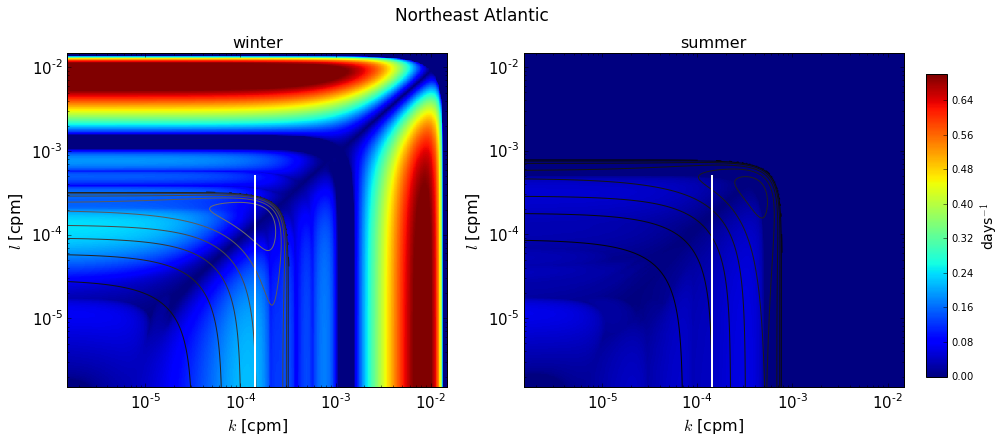

In [ ]:
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(121)
im = ax1.pcolormesh(k_winNEAt[Nwv:]*.5*np.pi**-1, l_winNEAt*.5*np.pi**-1, 
                    sigma2D_winNEAt[:, Nwv:]*24*3600,
              vmin=0., vmax=.7)
cnt1 = ax1.contour(k_winNEAt[Nwv:]*.5*np.pi**-1, l_winNEAt*.5*np.pi**-1, 
                   Eady_winNEAt[:, Nwv:]*24*3600,
                 cmap=cm.gray, vmin=0., vmax=.7)
ax1.plot(kr_NEAt, np.linspace((l_winNEAt*.5*np.pi**-1).min(), 
                              5e-4, 100), 'w', lw=2)
# ax1.semilogx(k_winK[Nwv:], Eady_winKuro1D[Nwv:]*24*3600)
ax1.set_title(r'winter', fontsize=16)
ax1.set_xlabel(r'$k$ [cpm]', fontsize=16)
ax1.set_ylabel(r'$l$ [cpm]', fontsize=16)
# ax1.clabel(cnt1, fontsize=10)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

ax2 = fig.add_subplot(122)
im = ax2.pcolormesh(k_sumNEAt[Nwv:]*.5*np.pi**-1, l_sumNEAt*.5*np.pi**-1, 
                    sigma2D_sumNEAt[:, Nwv:]*24*3600,
              vmin=0., vmax=.7)
cnt2 = ax2.contour(k_sumNEAt[Nwv:]*.5*np.pi**-1, l_sumNEAt*.5*np.pi**-1, 
                   Eady_sumNEAt[:, Nwv:]*24*3600,
                 cmap=cm.gray, vmin=0., vmax=.7)
ax2.plot(kr_NEAt, np.linspace((l_sumNEAt*.5*np.pi**-1).min(), 
                              5e-4, 100), 'w', lw=2)
# ax2.clabel(cnt2, fontsize=10)
# plt.clabel(cnt2, inline=1, fontsize=10)
ax2.set_title(r'summer', fontsize=16)
ax2.set_xlabel(r'$k$ [cpm]', fontsize=16)
ax2.set_ylabel(r'$l$ [cpm]', fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.suptitle('Northeast Atlantic', fontsize=17, y=1.007)
cbar_axim = fig.add_axes([0.92, 0.15, 0.02, 0.7])
# cbar_axcnt = fig.add_axes([0.98, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_axim)
# cbar = fig.colorbar(cnt, cbar_axcnt)
cbar.set_label(r'days$^{-1}$', fontsize=14)
plt.savefig('POP_NortheastAtlantic_2Dgrowthrate.png', bbox_inches='tight')

## Sargasso Sea

In [ ]:
lats_Sar = (23., 24.)
lons_Sar = (2.99900000e+02, 3.00900000e+02)

In [ ]:
dx_Sar = dx_meta.sel(Latitude_t=slice(lats_Sar[0], lats_Sar[1]), 
                    Longitude_t=slice(lons_Sar[0], lons_Sar[1])).values.copy()
dy_Sar = dy_meta.sel(Latitude_t=slice(lats_Sar[0], lats_Sar[1]), 
                    Longitude_t=slice(lons_Sar[0], lons_Sar[1])).values.copy()

kr_Sar = np.ones(100) * dx_Sar[jy, ix]**-1

In [ ]:
Ug_winSar = Ug_winmeta.sel(Latitude_t=slice(lats_Sar[0], lats_Sar[1]), 
                    Longitude_t=slice(lons_Sar[0], lons_Sar[1])).values.copy()
lat_Sar = Ug_winmeta.sel(Latitude_t=slice(lats_Sar[0], lats_Sar[1]), 
                    Longitude_t=slice(lons_Sar[0], lons_Sar[1])).Latitude_t.values.copy()
lon_Sar = Ug_winmeta.sel(Latitude_t=slice(lats_Sar[0], lats_Sar[1]), 
                    Longitude_t=slice(lons_Sar[0], lons_Sar[1])).Longitude_t.values.copy()
Vg_winSar = Vg_winmeta.sel(Latitude_t=slice(lats_Sar[0], lats_Sar[1]), 
                    Longitude_t=slice(lons_Sar[0], lons_Sar[1])).values.copy()
N2_winSar = N2_winmeta.sel(Latitude_t=slice(lats_Sar[0], lats_Sar[1]), 
                    Longitude_t=slice(lons_Sar[0], lons_Sar[1])).values.copy()
zN2_winSar = zN2_winmeta.sel(Latitude_t=slice(lats_Sar[0], lats_Sar[1]), 
                    Longitude_t=slice(lons_Sar[0], lons_Sar[1])).values.copy()
    
MLD_winSar = MLD_winmeta.sel(Latitude_t=slice(lats_Sar[0], lats_Sar[1]), 
                    Longitude_t=slice(lons_Sar[0], lons_Sar[1])).values.copy()
H_winSar = H_winmeta.sel(Latitude_t=slice(lats_Sar[0], lats_Sar[1]), 
                    Longitude_t=slice(lons_Sar[0], lons_Sar[1])).values.copy()
    
Ri_winSar = Ri_winmeta.sel(Latitude_t=slice(lats_Sar[0], lats_Sar[1]), 
                    Longitude_t=slice(lons_Sar[0], lons_Sar[1])).values.copy()

In [ ]:
Rix_winSar = Rix_winmeta.sel(Latitude_t=slice(lats_Sar[0], lats_Sar[1]), 
                    Longitude_t=slice(lons_Sar[0], lons_Sar[1])).values.copy()
Riy_winSar = Riy_winmeta.sel(Latitude_t=slice(lats_Sar[0], lats_Sar[1]), 
                    Longitude_t=slice(lons_Sar[0], lons_Sar[1])).values.copy()
kz_winSar = kz_winmeta.sel(Latitude_t=slice(lats_Sar[0], lats_Sar[1]), 
                    Longitude_t=slice(lons_Sar[0], lons_Sar[1])).values.copy()

In [ ]:
Ug_sumSar = Ug_summeta.sel(Latitude_t=slice(lats_Sar[0], lats_Sar[1]), 
                    Longitude_t=slice(lons_Sar[0], lons_Sar[1])).values.copy()
lat_Sar = Ug_summeta.sel(Latitude_t=slice(lats_Sar[0], lats_Sar[1]), 
                    Longitude_t=slice(lons_Sar[0], lons_Sar[1])).Latitude_t.values.copy()
lon_Sar = Ug_summeta.sel(Latitude_t=slice(lats_Sar[0], lats_Sar[1]), 
                    Longitude_t=slice(lons_Sar[0], lons_Sar[1])).Longitude_t.values.copy()
Vg_sumSar = Vg_summeta.sel(Latitude_t=slice(lats_Sar[0], lats_Sar[1]), 
                    Longitude_t=slice(lons_Sar[0], lons_Sar[1])).values.copy()
N2_sumSar = N2_summeta.sel(Latitude_t=slice(lats_Sar[0], lats_Sar[1]), 
                    Longitude_t=slice(lons_Sar[0], lons_Sar[1])).values.copy()
zN2_sumSar = zN2_summeta.sel(Latitude_t=slice(lats_Sar[0], lats_Sar[1]), 
                    Longitude_t=slice(lons_Sar[0], lons_Sar[1])).values.copy()
    
MLD_sumSar = MLD_summeta.sel(Latitude_t=slice(lats_Sar[0], lats_Sar[1]), 
                    Longitude_t=slice(lons_Sar[0], lons_Sar[1])).values.copy()
H_sumSar = H_summeta.sel(Latitude_t=slice(lats_Sar[0], lats_Sar[1]), 
                    Longitude_t=slice(lons_Sar[0], lons_Sar[1])).values.copy()
    
Ri_sumSar = Ri_summeta.sel(Latitude_t=slice(lats_Sar[0], lats_Sar[1]), 
                    Longitude_t=slice(lons_Sar[0], lons_Sar[1])).values.copy()

In [ ]:
Rix_sumSar = Rix_summeta.sel(Latitude_t=slice(lats_Sar[0], lats_Sar[1]), 
                    Longitude_t=slice(lons_Sar[0], lons_Sar[1])).values.copy()
Riy_sumSar = Riy_summeta.sel(Latitude_t=slice(lats_Sar[0], lats_Sar[1]), 
                    Longitude_t=slice(lons_Sar[0], lons_Sar[1])).values.copy()
kz_sumSar = kz_summeta.sel(Latitude_t=slice(lats_Sar[0], lats_Sar[1]), 
                    Longitude_t=slice(lons_Sar[0], lons_Sar[1])).values.copy()

In [ ]:
zphi, Rd, vd = baroclinic.neutral_modes_from_N2_profile(-zN2_winSar[:, jy, ix], 
                                                                                N2_winSar[:, jy, ix], gsw.earth.f(lat_Sar[jy]), **kwargs)

Rd_winSar = Rd[1]

In [ ]:
k_winSar, l_winSar, sigma2D_winSar, amp2D_winSar = baroclinic_instability(zN2_winSar[:, jy, ix], 
                                                                               N2_winSar[:, jy, ix], lat_Sar[jy], zU, 
                                                                               Ug_winSar[:, jy, ix], Vg_winSar[:, jy, ix], 
                                                                               etax, etay, Rd_winSar, kmin=0.1, kmax=1e3,
                                                                               Nwv=Nwv)

/home/takaya/oceanmodes/oceanmodes/baroclinic.py:568: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


In [ ]:
np.savez('POP_barocliGrowthrate_SargassoSea_win',
        k=k_winSar, l=l_winSar,
        growthrate=sigma2D_winSar, amplitude=amp2D_winSar)

In [ ]:
zphi, Rd, vd = baroclinic.neutral_modes_from_N2_profile(-zN2_sumSar[:, jy, ix], 
                                                                                N2_sumSar[:, jy, ix], gsw.earth.f(lat_Sar[jy]), **kwargs)

Rd_sumSar = Rd[1]

In [ ]:
k_sumSar, l_sumSar, sigma2D_sumSar, amp2D_sumSar = baroclinic_instability(zN2_sumSar[:, jy, ix], 
                                                                               N2_sumSar[:, jy, ix], lat_Sar[jy], zU, 
                                                                               Ug_sumSar[:, jy, ix], Vg_sumSar[:, jy, ix], 
                                                                               etax, etay, Rd_sumSar, kmin=0.1, kmax=1e3,
                                                                               Nwv=Nwv)

In [ ]:
np.savez('POP_barocliGrowthrate_SargassoSea_sum',
        k=k_sumSar, l=l_sumSar,
        growthrate=sigma2D_sumSar, amplitude=amp2D_sumSar)

In [203]:
Sarwinnpz = np.load(os.path.join(basedir, 'POP_barocliGrowthrate_SargassoSea_win.npz'))
print Sarwinnpz.files
k_winSar = Sarwinnpz['k']
l_winSar = Sarwinnpz['l']
sigma2D_winSar = Sarwinnpz['growthrate']
amp2D_winSar = Sarwinnpz['amplitude']

Sarsumnpz = np.load(os.path.join(basedir, 'POP_barocliGrowthrate_SargassoSea_sum.npz'))
print Sarsumnpz.files
k_sumSar = Sarsumnpz['k']
l_sumSar = Sarsumnpz['l']
sigma2D_sumSar = Sarsumnpz['growthrate']
amp2D_sumSar = Sarsumnpz['amplitude']

['k', 'l', 'amplitude', 'growthrate']
['k', 'l', 'amplitude', 'growthrate']


In [ ]:
Rd_MLwinSar = RdML(int(kz_winSar[jy, ix]), MLD_winSar[jy, ix],
                   lat_Sar[jy], zN2_winSar[:, jy, ix], N2_winSar[:, jy, ix], dzU)

In [ ]:
mu_winSar, Eady_winSar = Eady_growthrate(lat_Sar[jy], MLD_winSar[jy, ix], 
                            dzU, Rix_winSar[:, jy, ix], k_winSar, Rd_MLwinSar, Ri_y=Riy_winSar[:, jy, ix],
                            l=l_winSar, kz=int(kz_winSar[jy, ix]), dim=2)

In [ ]:
Rd_MLsumSar = RdML(int(kz_sumSar[jy, ix]), MLD_sumSar[jy, ix],
                   lat_Sar[jy], zN2_sumSar[:, jy, ix], N2_sumSar[:, jy, ix], dzU)

In [ ]:
mu_sumSar, Eady_sumSar = Eady_growthrate(lat_Sar[jy], MLD_sumSar[jy, ix], 
                            dzU, Rix_sumSar[:, jy, ix], k_sumSar, Rd_MLsumSar, Ri_y=Riy_sumSar[:, jy, ix],
                            l=l_sumSar, kz=int(kz_sumSar[jy, ix]), dim=2)

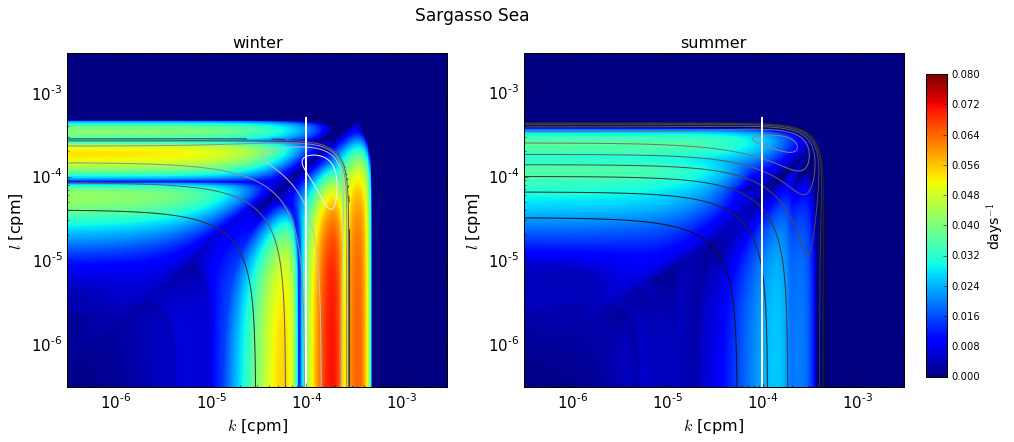

In [ ]:
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(121)
im = ax1.pcolormesh(k_winSar[Nwv:]*.5*np.pi**-1, l_winSar*.5*np.pi**-1, 
                    sigma2D_winSar[:, Nwv:]*24*3600,
              vmin=0., vmax=.08)
cnt1 = ax1.contour(k_winSar[Nwv:]*.5*np.pi**-1, l_winSar*.5*np.pi**-1, 
                   Eady_winSar[:, Nwv:]*24*3600,
                 cmap=cm.gray, vmin=0., vmax=.08)
ax1.plot(kr_Sar, np.linspace((l_winSar*.5*np.pi**-1).min(), 
                              5e-4, 100), 'w', lw=2)
# ax1.semilogx(k_winK[Nwv:], Eady_winKuro1D[Nwv:]*24*3600)
ax1.set_title(r'winter', fontsize=16)
ax1.set_xlabel(r'$k$ [cpm]', fontsize=16)
ax1.set_ylabel(r'$l$ [cpm]', fontsize=16)
# ax1.clabel(cnt1, fontsize=10)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

ax2 = fig.add_subplot(122)
im = ax2.pcolormesh(k_sumSar[Nwv:]*.5*np.pi**-1, l_sumSar*.5*np.pi**-1, 
                    sigma2D_sumSar[:, Nwv:]*24*3600,
              vmin=0., vmax=.08)
cnt2 = ax2.contour(k_sumSar[Nwv:]*.5*np.pi**-1, l_sumSar*.5*np.pi**-1, 
                   Eady_sumSar[:, Nwv:]*24*3600,
                 cmap=cm.gray, vmin=0., vmax=.08)
ax2.plot(kr_Sar, np.linspace((l_sumSar*.5*np.pi**-1).min(), 
                              5e-4, 100), 'w', lw=2)
# ax2.clabel(cnt2, fontsize=10)
# plt.clabel(cnt2, inline=1, fontsize=10)
ax2.set_title(r'summer', fontsize=16)
ax2.set_xlabel(r'$k$ [cpm]', fontsize=16)
ax2.set_ylabel(r'$l$ [cpm]', fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.suptitle('Sargasso Sea', fontsize=17, y=1.007)
cbar_axim = fig.add_axes([0.92, 0.15, 0.02, 0.7])
# cbar_axcnt = fig.add_axes([0.98, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_axim)
# cbar = fig.colorbar(cnt, cbar_axcnt)
cbar.set_label(r'days$^{-1}$', fontsize=14)
plt.savefig('POP_SargassoSea_2Dgrowthrate.png', bbox_inches='tight')

# Southern Ocean
## ACC

In [ ]:
lats_ACC = (-52., -51.)
lons_ACC = (1.49900000e+02, 1.50900000e+02)

In [ ]:
dx_ACC = dx_meta.sel(Latitude_t=slice(lats_ACC[0], lats_ACC[1]), 
                    Longitude_t=slice(lons_ACC[0], lons_ACC[1])).values.copy()
dy_ACC = dy_meta.sel(Latitude_t=slice(lats_ACC[0], lats_ACC[1]), 
                    Longitude_t=slice(lons_ACC[0], lons_ACC[1])).values.copy()

kr_ACC = np.ones(100) * dx_ACC[jy, ix]**-1

In [ ]:
Ug_winACC = Ug_winmeta.sel(Latitude_t=slice(lats_ACC[0], lats_ACC[1]), 
                    Longitude_t=slice(lons_ACC[0], lons_ACC[1])).values.copy()
lat_ACC = Ug_winmeta.sel(Latitude_t=slice(lats_ACC[0], lats_ACC[1]), 
                    Longitude_t=slice(lons_ACC[0], lons_ACC[1])).Latitude_t.values.copy()
lon_ACC = Ug_winmeta.sel(Latitude_t=slice(lats_ACC[0], lats_ACC[1]), 
                    Longitude_t=slice(lons_ACC[0], lons_ACC[1])).Longitude_t.values.copy()
Vg_winACC = Vg_winmeta.sel(Latitude_t=slice(lats_ACC[0], lats_ACC[1]), 
                    Longitude_t=slice(lons_ACC[0], lons_ACC[1])).values.copy()
N2_winACC = N2_winmeta.sel(Latitude_t=slice(lats_ACC[0], lats_ACC[1]), 
                    Longitude_t=slice(lons_ACC[0], lons_ACC[1])).values.copy()
zN2_winACC = zN2_winmeta.sel(Latitude_t=slice(lats_ACC[0], lats_ACC[1]), 
                    Longitude_t=slice(lons_ACC[0], lons_ACC[1])).values.copy()
    
MLD_winACC = MLD_winmeta.sel(Latitude_t=slice(lats_ACC[0], lats_ACC[1]), 
                    Longitude_t=slice(lons_ACC[0], lons_ACC[1])).values.copy()
H_winACC = H_winmeta.sel(Latitude_t=slice(lats_ACC[0], lats_ACC[1]), 
                    Longitude_t=slice(lons_ACC[0], lons_ACC[1])).values.copy()
    
Ri_winACC = Ri_winmeta.sel(Latitude_t=slice(lats_ACC[0], lats_ACC[1]), 
                    Longitude_t=slice(lons_ACC[0], lons_ACC[1])).values.copy()

In [ ]:
Rix_winACC = Rix_winmeta.sel(Latitude_t=slice(lats_ACC[0], lats_ACC[1]), 
                    Longitude_t=slice(lons_ACC[0], lons_ACC[1])).values.copy()
Riy_winACC = Riy_winmeta.sel(Latitude_t=slice(lats_ACC[0], lats_ACC[1]), 
                    Longitude_t=slice(lons_ACC[0], lons_ACC[1])).values.copy()
kz_winACC = kz_winmeta.sel(Latitude_t=slice(lats_ACC[0], lats_ACC[1]), 
                    Longitude_t=slice(lons_ACC[0], lons_ACC[1])).values.copy()

In [ ]:
Ug_sumACC = Ug_summeta.sel(Latitude_t=slice(lats_ACC[0], lats_ACC[1]), 
                    Longitude_t=slice(lons_ACC[0], lons_ACC[1])).values.copy()
Vg_sumACC = Vg_summeta.sel(Latitude_t=slice(lats_ACC[0], lats_ACC[1]), 
                    Longitude_t=slice(lons_ACC[0], lons_ACC[1])).values.copy()
N2_sumACC = N2_summeta.sel(Latitude_t=slice(lats_ACC[0], lats_ACC[1]), 
                    Longitude_t=slice(lons_ACC[0], lons_ACC[1])).values.copy()
zN2_sumACC = zN2_summeta.sel(Latitude_t=slice(lats_ACC[0], lats_ACC[1]), 
                    Longitude_t=slice(lons_ACC[0], lons_ACC[1])).values.copy()
    
MLD_sumACC = MLD_summeta.sel(Latitude_t=slice(lats_ACC[0], lats_ACC[1]), 
                    Longitude_t=slice(lons_ACC[0], lons_ACC[1])).values.copy()
H_sumACC = H_summeta.sel(Latitude_t=slice(lats_ACC[0], lats_ACC[1]), 
                    Longitude_t=slice(lons_ACC[0], lons_ACC[1])).values.copy()
    
Ri_sumACC = Ri_summeta.sel(Latitude_t=slice(lats_ACC[0], lats_ACC[1]), 
                    Longitude_t=slice(lons_ACC[0], lons_ACC[1])).values.copy()

In [ ]:
Rix_sumACC = Rix_summeta.sel(Latitude_t=slice(lats_ACC[0], lats_ACC[1]), 
                    Longitude_t=slice(lons_ACC[0], lons_ACC[1])).values.copy()
Riy_sumACC = Riy_summeta.sel(Latitude_t=slice(lats_ACC[0], lats_ACC[1]), 
                    Longitude_t=slice(lons_ACC[0], lons_ACC[1])).values.copy()
kz_sumACC = kz_summeta.sel(Latitude_t=slice(lats_ACC[0], lats_ACC[1]), 
                    Longitude_t=slice(lons_ACC[0], lons_ACC[1])).values.copy()

In [ ]:
zphi, Rd, vd = baroclinic.neutral_modes_from_N2_profile(-zN2_winACC[:, jy, ix], 
                                                                                N2_winACC[:, jy, ix], gsw.earth.f(lat_ACC[jy]), **kwargs)

Rd_winACC = Rd[1]

In [ ]:
k_winACC, l_winACC, sigma2D_winACC, amp2D_winACC = baroclinic_instability(zN2_winACC[:, jy, ix], 
                                                                               N2_winACC[:, jy, ix], lat_ACC[jy], zU, 
                                                                               Ug_winACC[:, jy, ix], Vg_winACC[:, jy, ix], 
                                                                               etax, etay, Rd_winACC, kmin=0.1, kmax=1e3,
                                                                               Nwv=Nwv)

KeyboardInterrupt: 

In [ ]:
np.savez('POP_barocliGrowthrate_ACC_win',
        k=k_winACC, l=l_winACC,
        growthrate=sigma2D_winACC, amplitude=amp2D_winACC)

In [ ]:
zphi, Rd, vd = baroclinic.neutral_modes_from_N2_profile(-zN2_sumACC[:, jy, ix], 
                                                                                N2_sumACC[:, jy, ix], gsw.earth.f(lat_ACC[jy]), **kwargs)

Rd_sumACC = Rd[1]

In [ ]:
k_sumACC, l_sumACC, sigma2D_sumACC, amp2D_sumACC = baroclinic_instability(zN2_sumACC[:, jy, ix], 
                                                                               N2_sumACC[:, jy, ix], lat_ACC[jy], zU, 
                                                                               Ug_sumACC[:, jy, ix], Vg_sumACC[:, jy, ix], 
                                                                               etax, etay, Rd_sumACC, kmin=0.1, kmax=1e3,
                                                                               Nwv=Nwv)

In [ ]:
np.savez('POP_barocliGrowthrate_ACC_sum',
        k=k_sumACC, l=l_sumACC,
        growthrate=sigma2D_sumACC, amplitude=amp2D_sumACC)

In [216]:
ACCwinnpz = np.load(os.path.join(basedir, 'POP_barocliGrowthrate_ACC_win.npz'))
print ACCwinnpz.files
k_winACC = ACCwinnpz['k']
l_winACC = ACCwinnpz['l']
sigma2D_winACC = ACCwinnpz['growthrate']
amp2D_winACC = ACCwinnpz['amplitude']

ACCsumnpz = np.load(os.path.join(basedir, 'POP_barocliGrowthrate_ACC_sum.npz'))
print ACCsumnpz.files
k_sumACC = ACCsumnpz['k']
l_sumACC = ACCsumnpz['l']
sigma2D_sumACC = ACCsumnpz['growthrate']
amp2D_sumACC = ACCsumnpz['amplitude']

['k', 'l', 'amplitude', 'growthrate']
['k', 'l', 'amplitude', 'growthrate']


In [ ]:
Rd_MLwinACC = RdML(int(kz_winACC[jy, ix]), MLD_winACC[jy, ix],
                   lat_ACC[jy], zN2_winACC[:, jy, ix], N2_winACC[:, jy, ix], dzU)

In [ ]:
mu_winACC, Eady_winACC = Eady_growthrate(lat_ACC[jy], MLD_winACC[jy, ix], 
                            dzU, Rix_winACC[:, jy, ix], k_winACC, Rd_MLwinACC, Ri_y=Riy_winACC[:, jy, ix],
                            l=l_winACC, kz=int(kz_winACC[jy, ix]), dim=2)

In [ ]:
Rd_MLsumACC = RdML(int(kz_sumACC[jy, ix]), MLD_sumACC[jy, ix],
                   lat_ACC[jy], zN2_sumACC[:, jy, ix], N2_sumACC[:, jy, ix], dzU)

In [ ]:
mu_sumACC, Eady_sumACC = Eady_growthrate(lat_ACC[jy], MLD_sumACC[jy, ix], 
                            dzU, Rix_sumACC[:, jy, ix], k_sumACC, Rd_MLsumACC, Ri_y=Riy_sumACC[:, jy, ix],
                            l=l_sumACC, kz=int(kz_sumACC[jy, ix]), dim=2)

In [ ]:
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(121)
im = ax1.pcolormesh(k_winACC[Nwv:]*.5*np.pi**-1, l_winACC*.5*np.pi**-1, 
                    sigma2D_winACC[:, Nwv:]*24*3600,
              vmin=0., vmax=.08)
cnt1 = ax1.contour(k_winACC[Nwv:]*.5*np.pi**-1, l_winACC*.5*np.pi**-1, 
                   Eady_winACC[:, Nwv:]*24*3600,
                 cmap=cm.gray, vmin=0., vmax=.08)
ax1.plot(kr_ACC, np.linspace((l_winACC*.5*np.pi**-1).min(), 
                              5e-4, 100), 'w', lw=2)
# ax1.semilogx(k_winK[Nwv:], Eady_winKuro1D[Nwv:]*24*3600)
ax1.set_title(r'summer', fontsize=16)
ax1.set_xlabel(r'$k$ [cpm]', fontsize=16)
ax1.set_ylabel(r'$l$ [cpm]', fontsize=16)
# ax1.clabel(cnt1, fontsize=10)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

ax2 = fig.add_subplot(122)
im = ax2.pcolormesh(k_sumACC[Nwv:]*.5*np.pi**-1, l_sumACC*.5*np.pi**-1, 
                    sigma2D_sumACC[:, Nwv:]*24*3600,
              vmin=0., vmax=.08)
cnt2 = ax2.contour(k_sumACC[Nwv:]*.5*np.pi**-1, l_sumACC*.5*np.pi**-1, 
                   Eady_sumACC[:, Nwv:]*24*3600,
                 cmap=cm.gray, vmin=0., vmax=.08)
ax2.plot(kr_ACC, np.linspace((l_sumACC*.5*np.pi**-1).min(), 
                              5e-4, 100), 'w', lw=2)
# ax2.clabel(cnt2, fontsize=10)
# plt.clabel(cnt2, inline=1, fontsize=10)
ax2.set_title(r'winter', fontsize=16)
ax2.set_xlabel(r'$k$ [cpm]', fontsize=16)
ax2.set_ylabel(r'$l$ [cpm]', fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.suptitle('ACC', fontsize=17, y=1.007)
cbar_axim = fig.add_axes([0.92, 0.15, 0.02, 0.7])
# cbar_axcnt = fig.add_axes([0.98, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_axim)
# cbar = fig.colorbar(cnt, cbar_axcnt)
cbar.set_label(r'days$^{-1}$', fontsize=14)
plt.savefig('POP_ACC_2Dgrowthrate.png', bbox_inches='tight')